# EcoMAT Sensory Data Pre-Processing and Analysis

## Description
This Jupyter notebook provides a detailed exposition of advanced data processing and analysis techniques tailored for handling multiple magnetics sensor data in EcoMAT project. The notebook is structured to guide the user through various sophisticated statistical and signal processing methods, enhancing the understanding and application of these techniques in real-world scenarios.

## Notebook Structure and Outline

1. **Data Loading and Preliminary Processing**
   - Scripts and instructions for loading sensor data from multiple files.
   - Initial data processing steps to prepare the data for detailed analysis.
   

2. **Sensor Test and Comparisons**
   - Load data from multiple sensor test experiments.
   - Set up drawing functions for comparison among multiple types of magnetic sensors.
   - Do the visualisation to check and select the best choice.

3. **Stability Analysis**
   - Methods and code for performing stability checks on the sensor data to determine consistent readings.
   - Comparison of different stability check methods such as standard deviation and customized heuristic checks.

4. **Event Detection**
   - Algorithms to detect specific events such as placement or removal of objects in sensor range, based on gradient and threshold analysis.
   - Visualization of event detection results to validate the effectiveness of the algorithms.

5. **Noise Characterization and Distribution Fitting**
   - Analysis of the noise characteristics inherent in the sensor data.
   - Fitting the noise data to a Gaussian distribution to understand its statistical properties.

6. **Conclusion**
   - Summary of the findings from the various analyses.
   - Discussion of potential improvements and future work to extend the capabilities of the analysis techniques.

By the end of this notebook, users will gain comprehensive insights into data processing in EcoMAT, enabling them to apply these methods effectively in their specific fields of research or application or reproduction of EcoMAT results.


In [1]:
import numpy as np
import scipy as sp
from scipy.signal import savgol_filter
from matplotlib.ticker import ScalarFormatter

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_theme()

### Loading Data

This section of the notebook focuses on loading the SS496A1 data from a text file and converting it into a NumPy array for further analysis. The data is initially read into a pandas DataFrame to facilitate easy handling and then converted to a NumPy array which is more suitable for numerical operations in analysis steps that follow.

In [40]:
ss496a1_raw = pd.read_csv("./sensor-test/nov-9-ss496a1-prlm-stm32-test.txt", names=["ss496a1"])
data = ss496a1_raw['ss496a1'].to_numpy()
data

array([2630.625 , 2630.625 , 2630.4375, 2630.625 , 2630.0625, 2630.4375,
       2630.0625, 2630.25  , 2630.25  , 2630.8125, 2630.625 , 2615.0625,
       2615.25  , 2615.4375, 2615.0625, 2615.0625, 2615.4375, 2615.25  ,
       2614.875 , 2615.4375, 2614.875 , 2614.875 , 2607.375 , 2607.9375,
       2607.1875, 2606.625 , 2607.375 , 2607.1875, 2607.1875, 2607.    ,
       2607.1875, 2607.375 , 2607.375 , 2605.125 , 2604.75  , 2605.3125,
       2605.125 , 2605.125 , 2604.9375, 2604.75  , 2604.75  , 2605.5   ,
       2604.75  , 2604.9375, 2604.75  , 2604.375 , 2604.    , 2604.375 ,
       2604.375 , 2604.375 , 2604.9375, 2604.375 , 2604.375 , 2604.5625,
       2604.75  , 2604.1875, 2603.8125, 2604.375 , 2604.375 , 2604.1875,
       2604.1875, 2604.375 , 2604.75  , 2604.375 , 2604.1875, 2604.75  ,
       2604.375 , 2604.75  , 2604.1875, 2604.5625, 2604.5625, 2604.5625,
       2604.75  , 2604.5625, 2604.9375, 2604.375 , 2604.5625, 2604.375 ,
       2604.75  , 2604.5625, 2604.9375, 2604.5625, 

### Plotting Magnetic Field Strength Distribution for SS496A1 Sensor

This section of the notebook features a function, `plot_ss496_test`, designed to load and plot the magnetic field strength data captured by the SS496A1 sensor at various distances. The function is crafted to offer insights into how the field strength varies as a function of distance from the sensor. Here's a breakdown of the function's workflow:

- **Data Loading**: The function begins by loading the sensor data from a specified file path into a pandas DataFrame and then converting this data into a NumPy array for easier manipulation.
- **Data Slicing**: It calculates a starting index based on a given starting distance, adjusting for the fact that the data for different distances are segmented within the dataset. This allows the function to focus on a specific segment of the data corresponding to the desired starting distance.
- **Data Grouping and Visualization**: The function groups the data into chunks, each representing the data collected at a specific distance, and then uses a violin plot to visually represent the distribution of magnetic field strengths at these distances. This helps in identifying trends or anomalies in the sensor data at different ranges.
- **Plot Customization**: Detailed customization of the plot includes setting color, transparency, median visibility, and axis labels to enhance readability and interpretability of the visual data representation.

Example usage of this function is demonstrated to plot the data starting from a distance of 3 cm with data grouped in chunks of 11 measurements each. This showcases the variability and general trends in magnetic field strength as distance from the sensor increases.


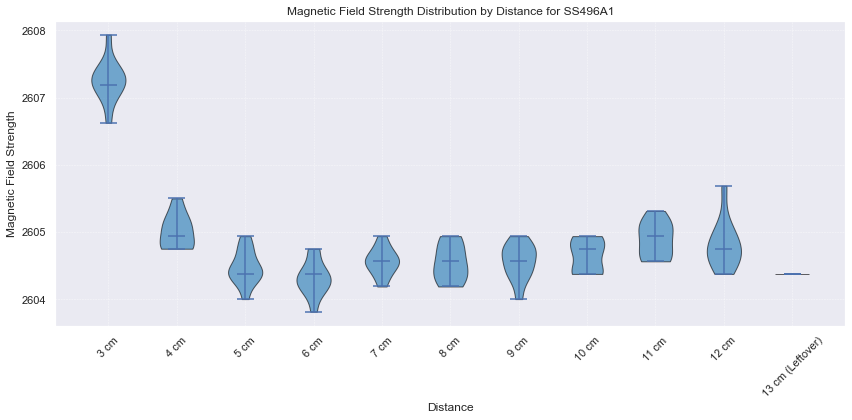

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_ss496_test(file_path, start_distance=1, chunk_size=11):
    # Load the data from a CSV file
    ss496a1_raw = pd.read_csv(file_path, names=["ss496a1"])

    # Convert data to numpy array for easier manipulation
    data = ss496a1_raw['ss496a1'].to_numpy()

    # Calculate the starting index based on the starting distance
    # start_distance of 1 corresponds to index 0; start_distance of 15 corresponds to index 140 (when chunk_size=11)
    start_index = (start_distance - 1) * chunk_size
    if start_index >= len(data):
        raise ValueError("Starting distance is out of the range of the dataset")

    # Slice the data starting from the calculated start index
    data_sliced = data[start_index:]

    # Determine how many full groups we have based on the chunk size
    num_groups = len(data_sliced) // chunk_size
    leftover = len(data_sliced) % chunk_size

    # Prepare data for plotting
    distances = [f"{start_distance + i} cm" for i in range(num_groups)]
    violin_data = [data_sliced[i * chunk_size: (i + 1) * chunk_size] for i in range(num_groups)]
    
    # Check if there are any leftover data points
    if leftover > 0:
        violin_data.append(data_sliced[-leftover:])
        distances.append(f"{start_distance + num_groups} cm (Leftover)")

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create the violin plot
    parts = ax.violinplot(violin_data, showmeans=False, showmedians=True)

    # Customize the violin plot colors and appearance
    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b4')
        pc.set_edgecolor('black')
        pc.set_alpha(0.6)

    # Customizing axis labels and title
    ax.set_xticks(np.arange(1, len(distances) + 1))
    ax.set_xticklabels(distances)
    ax.set_xlabel('Distance')
    ax.set_ylabel('Magnetic Field Strength')
    ax.set_title('Magnetic Field Strength Distribution by Distance for SS496A1')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example function call with starting distance of 15 and chunk size of 11
file_path = "./sensor-test/nov-9-ss496a1-prlm-stm32-test.txt"
plot_ss496_test(file_path, start_distance=3, chunk_size=11)


### Visualization of DRV425 Sensor Readings by Distance

The function `plot_drv425_test` is designed to analyze and visualize the magnetic field readings collected by the DRV425 sensor across different distances. Here's how the function processes and visualizes the data:

- **Data Loading**: It starts by loading magnetic field strength data from a specific test file into a pandas DataFrame, indexing the readings along with their corresponding distances.
- **Data Preparation**: The dataset is structured so that the last 20 measurements (at 31 cm) are considered baseline readings. The function computes a mean of these baseline readings to establish a base level for adjustments.
- **Reading Adjustment**: To account for any consistent offset in the sensor readings, the base level is subtracted from all individual readings in the dataset.
- **Data Filtering**: The function filters the data to include only the readings between the specified starting distance (`distance_start`) and 30 cm, excluding the baseline readings.
- **Visualization**: For visual analysis, a violin plot is generated, which shows the distribution of the adjusted readings for each distance. The plot highlights the mean of the distributions and provides a detailed view of the variability of readings at each distance.

This approach helps in identifying variations in sensor performance across different distances and assessing the stability and reliability of the sensor under test conditions. The visualization is particularly useful for spotting anomalies or trends that might not be evident from raw data alone.



In [26]:

def plot_drv425_test(distance_start, ):

    drv425evm_raw = pd.read_csv("./sensor-test/nov-9-drv425-prlm-stm32-distance-test.txt", names=["prlm_drv425"])

    df = pd.DataFrame({"distance":np.repeat(np.arange(3, 32), 20),"reading": np.array(drv425evm_raw["prlm_drv425"])})

    # Identify and mark the base readings which are the last 20 rows for distance '31'
    base_readings = df[df['distance'] == 31]['reading']

    # Smooth the base readings by calculating the mean
    base_reading_smooth = base_readings.mean()

    # Subtract the smooth base reading from all readings
    df['adjusted_reading'] = df['reading'] - base_reading_smooth

    # df['adjusted_reading'] *= 0.0204918

    # Filter the DataFrame for distances 20cm to 30cm (excluding base reading at 31)
    filtered_df = df[(df['distance'] >= distance_start) & (df['distance'] < 31)]

    # Prepare the data for violin plotting
    distances = np.unique(filtered_df['distance'])
    data_to_plot = [filtered_df[filtered_df['distance'] == dist]['adjusted_reading'].values for dist in distances]

    # Create the violin plot using Matplotlib
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.violinplot(data_to_plot, positions=distances, showmeans=True, showmedians=False)

    ax.set_title('Distribution of Adjusted Readings by Distance (20cm to 30cm)', fontsize=20)
    ax.set_xlabel('Distance (cm)', fontsize=20)
    ax.set_ylabel('Adjusted Reading', fontsize=20)
    ax.set_xticks(distances)
    ax.set_xticklabels([f"{int(dist)}" for dist in distances])
    plt.tick_params(axis='both', which='major', labelsize=18)  # Enlarge major tick labels
    plt.tick_params(axis='both', which='minor', labelsize=18)  # Enlarge minor tick labels if used
    plt.grid(True)
    plt.show()

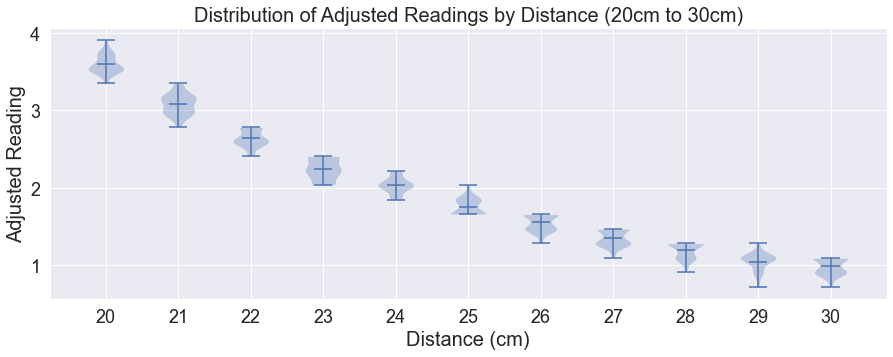

In [27]:
plot_drv425_test(distance_start=20)

### Magnetic Field Strength Distribution Analysis for LIS3MDL Sensor

The function `plot_lis3mdl_test` is designed to process and visualize the magnetic field strength data collected from the LIS3MDL sensor across various distances. Here’s a breakdown of how the function works:

- **Data Loading**: The function starts by loading the data from a specified CSV file. This data includes readings for three axes (x, y, z) across multiple sensors and additional parameters like orientation and location.

- **Data Selection and Processing**: 
  - The y-axis data for the magnetic field readings (`slave_mg->reading_float.axis.y`) are extracted and converted into a numpy array for processing.
  - The starting index for data slicing is calculated based on a given `start_distance`, allowing the analysis to focus on specific parts of the data sequence.

- **Data Chunking**:
  - The data are divided into chunks of 10 readings each, starting from the `start_index`. This chunking helps in analyzing the data in smaller, more manageable segments.
  - If there are any leftover readings after chunking (less than 10), they are labeled as 'Magnet Removed' to indicate an incomplete data set at the end of the measurement series.

- **Visualization**:
  - A violin plot is generated to visualize the distribution of magnetic field strengths for each chunk of data. This plot helps in understanding the variability and central tendency of the magnetic field at different distances.
  - Customization options like color, median display, and grid lines enhance the plot’s readability and aesthetic appeal.

This function is particularly useful for analyzing how the magnetic strength varies with distance in sensor testing scenarios, providing insights into the sensor’s performance and characteristics.



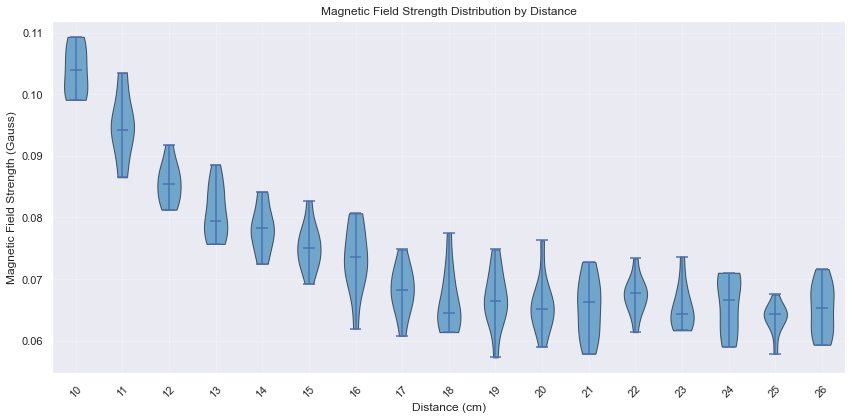

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_lis3mdl_test(file_path, start_distance=1):
    # Read the data
    lis3mdl_raw = pd.read_csv(file_path, sep="' ", engine="python",
                              names=["slave_xl->reading_float.axis.x", "slave_xl->reading_float.axis.y", "slave_xl->reading_float.axis.z",
                                     "slave_gr->reading_float.axis.x", "slave_gr->reading_float.axis.y", "slave_gr->reading_float.axis.z",
                                     "slave_mg->reading_float.axis.x", "slave_mg->reading_float.axis.y", "slave_mg->reading_float.axis.z",
                                     "orientation->angle.roll", "orientation->angle.pitch", "orientation->angle.yaw",
                                     "location->axis.x", "location->axis.y", "location->axis.z"])

    # Select the desired axis and convert to numpy array, skipping the first element
    y_data = lis3mdl_raw["slave_mg->reading_float.axis.y"].to_numpy()[1:]

    # Adjust starting index based on the starting distance
    start_index = (start_distance - 1) * 10
    y_data_sliced = y_data[start_index:]
    num_full_chunks = len(y_data_sliced) // 10

    # Prepare the data for each chunk
    distances = list(range(start_distance, start_distance + num_full_chunks))
    data = [y_data_sliced[i*10:(i+1)*10] for i in range(num_full_chunks)]

    # If there are leftovers, consider them as 'Magnet Removed'
    if len(y_data_sliced) % 10 != 0:
        data.append(y_data_sliced[-(len(y_data_sliced) % 10):])
        distances.append('Magnet Removed')

    # Prepare the violin plot data
    violin_data = []
    for d in data:
        if len(d) > 0:
            violin_data.append(d)

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create the violin plot
    parts = ax.violinplot(violin_data, showmeans=False, showmedians=True)

    # Customizing the violin plot colors
    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b4')
        pc.set_edgecolor('black')
        pc.set_alpha(0.6)

    # Adding custom labels to the x-axis
    ax.set_xticks(np.arange(1, len(distances) + 1))
    ax.set_xticklabels(distances)
    ax.set_xlim(0.5, len(distances) + 0.5)  # Set the limits of the x-axis

    # Setting the labels and title
    ax.set_xlabel('Distance (cm)')
    ax.set_ylabel('Magnetic Field Strength (Gauss)')
    ax.set_title('Magnetic Field Strength Distribution by Distance')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Custom grid line style

    plt.xticks(rotation=45)  # Rotate x labels for better visibility
    plt.tight_layout()  # Adjust layout
    plt.show()

# Example function call
file_path = "./sensor-test/oct-30-lis3mdl-prlm-stm32-distance-test.txt"
plot_lis3mdl_test(file_path, start_distance=10)


### Moving Average Calculation

The function `moving_average` is designed to smooth out data series by calculating the moving average, which helps in identifying trends by minimizing the noise in data observations. Here’s how it works:

- **Window Creation**:
  - A window, or kernel, is created based on the specified `window_size`. This window is essentially an array of equal values that sum to one, ensuring that the average within the window is computed correctly.
  
- **Convolution Operation**:
  - The function applies a convolution operation between the data array and the window. Convolution is a mathematical operation used to derive the integral of two functions, which in this context, helps in applying the moving average filter to the data.
  - The `mode='valid'` in the convolution ensures that the resulting array of smoothed data is only computed where the window fits completely within the input data array. This avoids boundary effects where incomplete windows would distort the average at the start and end of the data series.

- **Output**:
  - The smoothed data, which is an array of the moving averages, is returned. This array is shorter than the input data by `window_size - 1` due to the 'valid' mode of convolution.

This moving average function is particularly useful in data analysis for smoothing out short-term fluctuations and highlighting longer-term trends or cycles.


In [29]:

def moving_average(data, window_size):
    # Create a window/kernel for the moving average
    window = np.ones(window_size) / window_size
    # Apply convolution between your data and the window
    smoothed_data = np.convolve(data, window, mode='valid')
    return smoothed_data

In [30]:
np.linspace(0,15848, 15848)

array([0.00000000e+00, 1.00006310e+00, 2.00012621e+00, ...,
       1.58459999e+04, 1.58469999e+04, 1.58480000e+04])

### Plotting Data Channels and Their Gradients

This script includes two main functions for visualizing data from multiple sensors. Both functions are designed to handle time series data for various applications, including signal processing and analysis in sensor networks or similar scenarios.

#### Function `plot_3_channels`
- **Purpose**: Plots up to three channels of data from a DataFrame. It includes options for smoothing the data using a Savitzky-Golay filter.
- **Parameters**:
  - `raw_df`: DataFrame containing the signal data.
  - `filtering`: Boolean to decide whether to apply filtering.
  - `filter_func`: The filtering function used if `filtering` is True. Default is `savgol_filter`.
  - `window_length`, `polyorder`: Parameters for the Savitzky-Golay filter.
  - `no_of_anchors_to_plot`: The number of channels to plot (up to 3).
- **Functionality**:
  - Iterates through the specified number of channels.
  - Optionally applies a Savitzky-Golay filter to smooth the data.
  - Plots each channel in a separate subplot, labeling each plot based on whether the data was filtered.
  - Formats the x and y axes to display plain numbers without scientific notation.

#### Function `plot_3_channels_with_gradients`
- **Purpose**: Extends the `plot_3_channels` functionality by also plotting the gradient of each channel, providing insights into the rate of change in signals.
- **Parameters**:
  - Inherits all parameters from `plot_3_channels` except for `no_of_anchors_to_plot`, assuming the first three columns are channels.
  - `filtering`: Applies Savitzky-Golay filtering by default.
- **Functionality**:
  - For each of the first three columns (channels) in the DataFrame:
    - Computes the gradient of the channel to show rate of change.
    - Plots both the original data and its gradient in consecutive subplots.
    - Labels and formats plots appropriately to differentiate between the original data and gradient.
    - Adds legends and adjusts layout for clear visualization.

### Example Usage
- To visualize the data with gradients:
  ```python
  plot_3_channels_with_gradients(raw_df, start_distance=3, chunk_size=11)


In [32]:
def plot_3_channels(raw_df, filtering=False, filter_func=savgol_filter, window_length=51, polyorder=2, no_of_anchors_to_plot=3):
    from matplotlib.ticker import ScalarFormatter

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(no_of_anchors_to_plot, 1, figsize=(10, 15), dpi=200)

    # Define a plain number formatter
    formatter = ScalarFormatter(useOffset=False)

    for i, column in enumerate(raw_df.columns):

        if (i + 1 > no_of_anchors_to_plot):
            continue

        # check if filtering is required for the drawing
        # if YES, run the filtering algo before execute the drawing commands
        data = raw_df[column]
        if (filtering):
            data = filter_func(data, window_length, polyorder)

        axs[i].plot(raw_df.index, data)
        if (filtering): axs[i].set_title(column + " smoothed with savgol filter: window len of 51")
        else : axs[i].set_title(column + " no filtering")
        axs[i].set_xlabel("Samples(100 samples/sec)")
        axs[i].set_ylabel('Field Strength(mV)')

        # Apply plain number format to both x and y axis
        axs[i].xaxis.set_major_formatter(formatter)
        axs[i].yaxis.set_major_formatter(formatter)

    # Adjust the layout
    plt.tight_layout()

    # Display the plot
    plt.show()



def plot_3_channels_with_gradients(raw_df, filtering=True, window_length=51, polyorder=2):
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(6, 1, figsize=(10, 12), dpi=200)  # 6 subplots for 3 channels and their gradients

    # Define a plain number formatter
    formatter = ScalarFormatter(useOffset=False)

    for i, column in enumerate(raw_df.columns[:3]):  # Assume first 3 columns are channels
        data = raw_df[column]
        if filtering:
            data = savgol_filter(data, window_length, polyorder)
        
        # Calculate the gradient
        gradient = np.gradient(data)

        # Plot the original data
        axs[2*i].plot(raw_df.index, data, label=f'Original Data')
        axs[2*i].set_title(f'{column} Data')
        axs[2*i].set_ylabel('Field Strength (mV)')
        axs[2*i].xaxis.set_major_formatter(formatter)
        axs[2*i].yaxis.set_major_formatter(formatter)

        # Plot the gradient
        axs[2*i + 1].plot(raw_df.index, gradient, label='Gradient', color='orange')
        axs[2*i + 1].set_title(f'{column} Gradient')
        axs[2*i + 1].set_ylabel('Gradient (mV/sample)')
        axs[2*i + 1].xaxis.set_major_formatter(formatter)
        axs[2*i + 1].yaxis.set_major_formatter(formatter)

    # Set the xlabel for the last subplot only
    axs[-1].set_xlabel('Samples (100 samples/sec)')

    # Add legends
    for ax in axs:
        ax.legend()

    plt.tight_layout()
    plt.show()

# Assuming raw_df is your DataFrame with the data
# plot_3_channels_with_gradients(raw_df)



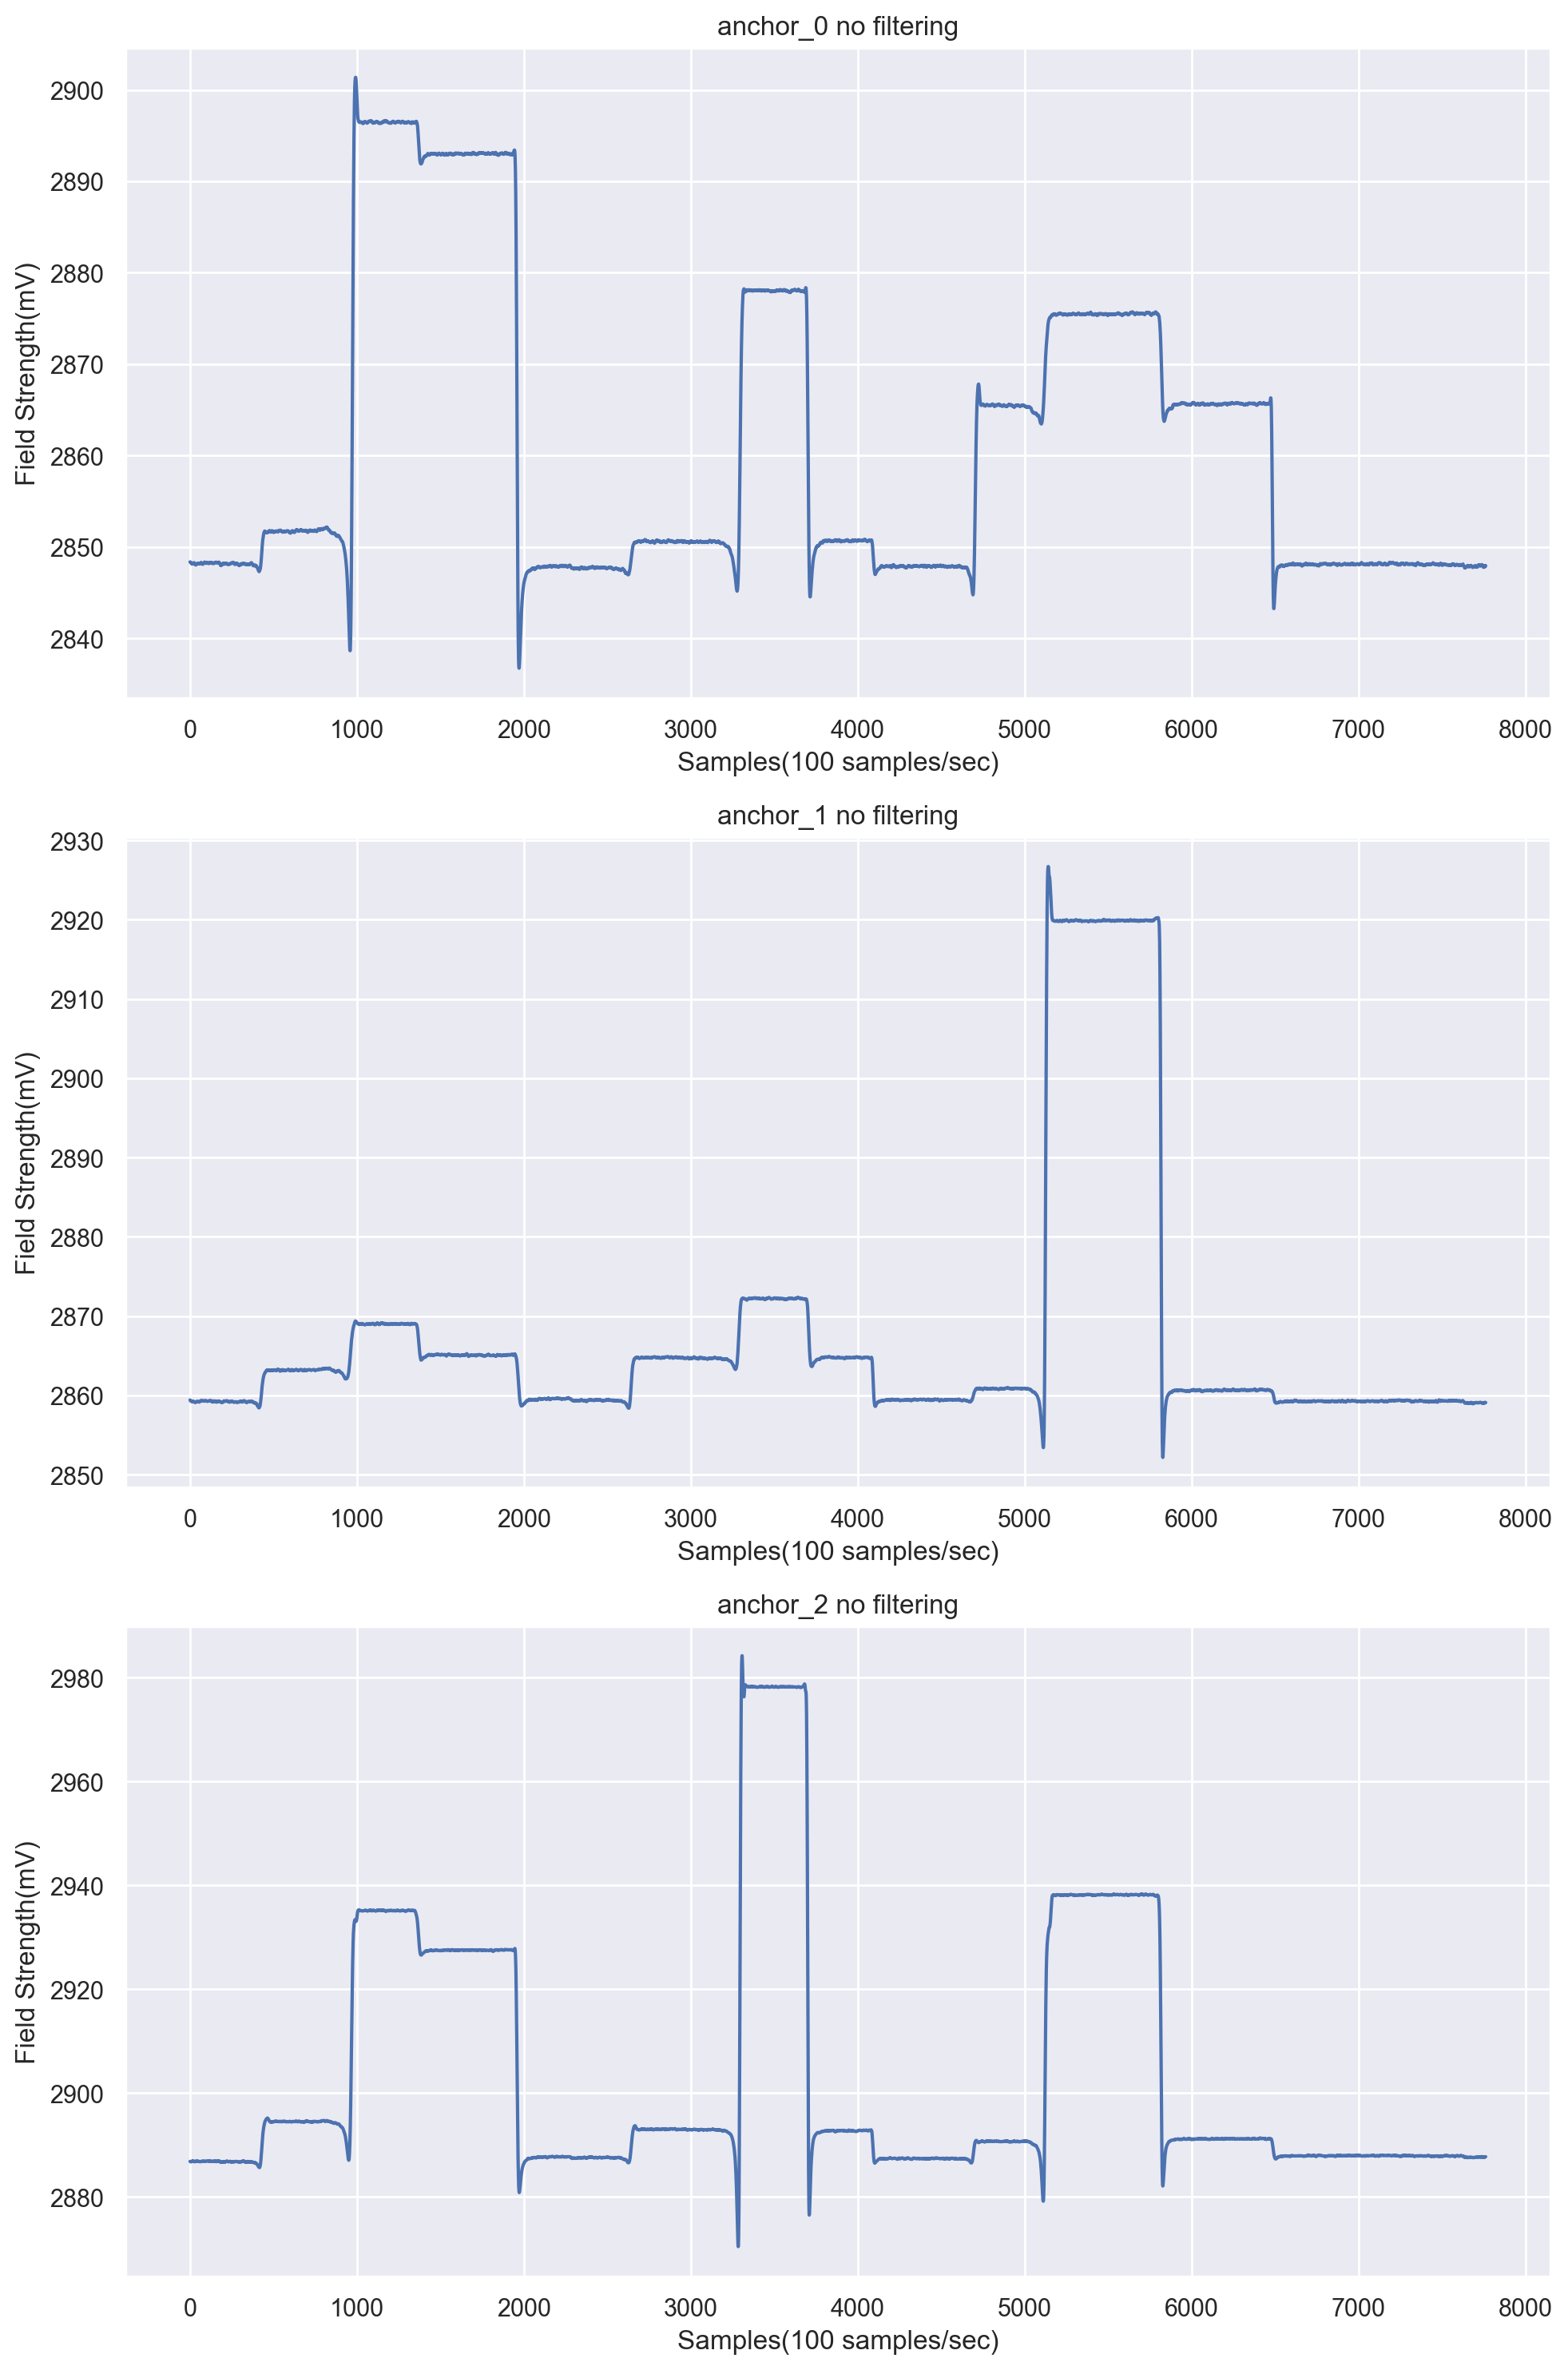

In [33]:
raw_df_cur = pd.read_csv("./../data/feb-12-PRM-and-PRMM-place-remove-3-times.txt", names=["anchor_0", "anchor_1", "anchor_2"])
plot_3_channels(raw_df_cur)

### Data Loading for Multiple Sensor Deployments

This section of the script is dedicated to loading data from various sensor tests and deployments into pandas DataFrames. Each CSV file corresponds to a specific setup or test condition, and the data is loaded with appropriate column names for each sensor anchor. This setup facilitates the analysis of sensor outputs under different conditions, such as proximity to server racks and interaction.


In [35]:
raw_df_first = pd.read_csv("../data/feb-1-multi-sensor-deploy-test.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_second = pd.read_csv("../data/feb-1-multi-sensor-deploy-test-second.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_third = pd.read_csv("../data/feb-1-multi-sensor-deploy-test-no-action.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_20cm_from_server_laptop_battery = pd.read_csv("../data/feb-5-multi-sensor-deploy-test-20cm-from-server-rack-laptop-battery.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_20cm_from_server_power_cable = pd.read_csv("../data/feb-5-multi-sensor-deploy-test-20cm-from-server-rack-power-cable.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_120cm_from_server_power_cable = pd.read_csv("../data/feb-5-multi-sensor-deploy-test-120cm-from-server-rack-power-cable.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_120cm_from_server_laptop_battery = pd.read_csv("../data/feb-5-multi-sensor-deploy-test-120cm-from-server-rack-laptop-battery.txt", names=["anchor_0", "anchor_1", "anchor_2"])

raw_df_PRMM_laptop_battery_single = pd.read_csv("../data/feb-5-PRMM-single-place-remove-laptop-battery.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRMM_laptop_battery_multiple = pd.read_csv("../data/feb-5-PRMM-multi-place-remove-laptop-battery.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRMM_laptop_battery_multiple_bottle_height_2 = pd.read_csv("../data/feb-5-PRMM-multi-place-remove-bottle-laptop-battery-sensor-height-2-magnet-height-2cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRMM_laptop_battery_multiple_bottle_height_3 = pd.read_csv("../data/feb-5-PRMM-multi-place-remove-bottle-laptop-battery-sensor-height-3-magnet-height-2cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_laptop_battery_multiple_bottle_height_3 = pd.read_csv("../data/feb-5-PRM-multi-place-remove-bottle-laptop-battery-sensor-height-3-magnet-height-2cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_laptop_battery_multiple_bottle_sensor_height_3_magnet_height_0cm = pd.read_csv("../data/feb-5-PRM-multi-place-remove-bottle-laptop-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_laptop_battery_multiple_no_bottle_sensor_height_3_magnet_height_0cm = pd.read_csv("../data/feb-5-PRM-multi-place-remove-no-bottle-laptop-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])

raw_df_PRM_cable_static = pd.read_csv("../data/feb-7-PRM-static-cable-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_battery_static = pd.read_csv("../data/feb-7-PRM-static-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRM_static_PRMM_move_battery = pd.read_csv("../data/feb-7-PRM-static-PRMM-place-remove-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])
raw_df_PRMM_static_PRM_move_battery = pd.read_csv("../data/feb-7-PRMM-static-PRM-place-remove-battery-sensor-height-3-magnet-height-0cm.txt", names=["anchor_0", "anchor_1", "anchor_2"])



raw_df_PRM_PRMM_place_remove_3_times = pd.read_csv("../data/feb-12-PRM-and-PRMM-place-remove-3-times.txt", names=["anchor_0", "anchor_1", "anchor_2"])

### Cross-Correlation and Peak Detection in Sensor Data

This function, `correlate_channel_template`, is designed to perform a cross-correlation between sensor data and a specified template. This analysis helps in identifying patterns similar to the template within the data stream. Here's what the function does:

1. **Gradient Calculation**: It computes the gradient of the sensor data to highlight changes over samples, enhancing pattern recognition during cross-correlation.
2. **Template Adjustment**: If specified, the function modifies the template to include only positive values, or it retains the original based on the `positive_template_flag`.
3. **Data Cleansing**: It checks and corrects any NaN or infinite values within the sensor data or template to ensure proper mathematical operations.
4. **Cross-Correlation Execution**: It performs the cross-correlation between the gradient of the data and the template, and then normalizes the result.
5. **Peak Detection**: The function identifies significant peaks in the normalized correlation, which indicate strong similarities to the template at specific points in the data.
6. **Visualization**: It plots the original data, the data gradient, the normalized correlation, and the template for visual analysis. Peaks identified in the correlation are marked on the plots to show where the data closely matches the template.

This function is particularly useful in signal processing applications where identifying the occurrence of a specific event or pattern within a large dataset is required. The visualization component provides a clear and intuitive representation of where these patterns occur relative to the template.

**Example Usage**:
To use this function, you would typically pass a numpy array representing your sensor data and another array as the template. Here is a commented-out example for clarity:

```python
# data_stream = np.array([...])  # Your data here
# template = np.array([...])  # Your template here
# correlate_channel_template(data_stream, template, 'Data Stream', 'Template')


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks

def correlate_channel_template(data_stream, template, data_name, template_name, positive_template_flag=True):
    channel_data = data_stream
    channel_gradient = np.gradient(channel_data)

    # Replace negative values in the template with zeros, if flagged
    gradient_val_template = np.maximum(template, 0) if positive_template_flag else template


    # Check and handle NaNs and Infs before correlation
    if np.isnan(gradient_val_template).any() or np.isnan(channel_gradient).any():
        print("Warning: NaN values found in the data. They will be replaced with zeros.")
        gradient_val_template = np.nan_to_num(gradient_val_template)
        channel_gradient = np.nan_to_num(channel_gradient)

    if np.isinf(gradient_val_template).any() or np.isinf(channel_gradient).any():
        print("Warning: Infinite values found in the data. They will be replaced with large finite numbers.")
        gradient_val_template = np.nan_to_num(gradient_val_template, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
        channel_gradient = np.nan_to_num(channel_gradient, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

    # Perform cross-correlation
    print(channel_gradient)
    print(gradient_val_template)
    correlation = correlate(channel_gradient, gradient_val_template, mode='full')
    # print(channel_gradient)
    # print(gradient_val_template)
    # print(correlation)
    normalized_correlation = correlation / np.max(correlation)  # Normalize the correlation

    # Find both positive and negative peaks in the correlation result
    peaks_positive, _ = find_peaks(normalized_correlation, prominence=0.8)
    print(peaks_positive)
    peaks_negative, _ = find_peaks(-normalized_correlation, prominence=0.8)
    print(peaks_negative)
    # Merge and sort peaks
    peaks_corr = np.sort(np.concatenate((peaks_positive, peaks_negative)))

    # Set up subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 8), dpi=300)

    # Plot channel data and mark peaks based on correlation
    axs[0].plot(channel_data, label=f'{data_name} Data')
    for peak in peaks_corr:
        # Map correlation index to data index
        data_index = peak - len(gradient_val_template) // 2
        if 0 <= data_index < len(channel_data):
            axs[0].plot(data_index, channel_data[data_index], "x", color='red')
    axs[0].set_title(f'{data_name} Channel Data')
    axs[0].set_xlabel('Samples')
    axs[0].set_ylabel('Field Strength (mV)')

    # Plot channel gradient and mark peaks based on correlation
    axs[1].plot(channel_gradient, color='orange', label=f'{data_name} Gradient')
    for peak in peaks_corr:
        data_index = peak - len(gradient_val_template) // 2
        if 0 <= data_index < len(channel_gradient):
            axs[1].plot(data_index, channel_gradient[data_index], "x", color='red')
    axs[1].set_title(f'{data_name} Channel Gradient')
    axs[1].set_xlabel('Samples')
    axs[1].set_ylabel('Gradient (mV/sample)')

    # Plot cross-correlation result and mark peaks
    print(normalized_correlation)
    axs[2].plot(normalized_correlation, label='Normalized Correlation')
    axs[2].plot(peaks_positive, normalized_correlation[peaks_positive], "x", color='green', label='Positive Peaks')
    axs[2].plot(peaks_negative, normalized_correlation[peaks_negative], "x", color='blue', label='Negative Peaks')
    axs[2].set_title(f'Normalized Cross-Correlation between {data_name} and {template_name}')
    axs[2].set_xlabel('Lag')
    axs[2].set_ylabel('Correlation Coefficient')
    axs[2].legend(loc="lower right", prop={'size': 6})

    # Plot the template
    axs[3].plot(gradient_val_template, label='Template')
    axs[3].set_title(f'Template: {template_name}')
    axs[3].set_xlabel('Samples')
    axs[3].set_ylabel("Gradient (mV/sample)")
    axs[3].legend()

    plt.tight_layout()
    plt.show()

# Example usage
# data_stream = np.array([...])  # Your data here
# template = np.array([...])  # Your template here
# correlate_channel_template(data_stream, template, 'Data Stream', 'Template')



### Stability Check Function Overview

The function `stability_check` evaluates the stability of a system or process based on its derivative data, divided into specified chunks. Here's a detailed breakdown of what this function accomplishes:

1. **Data Segmentation**: It takes an array of derivative values, presumably representing changes over time or samples, and splits this into smaller segments (chunks).
2. **Summation of Derivative Values**: For each chunk, it calculates the sum of the absolute values of the derivatives, effectively measuring the total change within that segment.
3. **Threshold Comparison**: Each summed value is then compared against a predefined threshold for that segment. The thresholds array should contain limit values that define what is considered stable for each segment.
4. **Stability Evaluation**: The function returns `True` if all segments are below their respective thresholds, indicating that the system is in a stable state throughout the observation period. Otherwise, it returns `False`, signaling instability or significant changes during some segments.

This method is particularly useful for systems where stability is defined by the absence of large fluctuations or changes over specific intervals. It can be applied in various fields, such as signal processing, financial market analysis, or any scenario where measuring the consistency or stability over time is crucial.

**Example Usage**:
You might use this function to check the stability of sensor data, financial data points, or any sequential dataset where rapid changes signify critical events or issues:

```python
# derivative_array = np.array([...])  # Your derivative data here
# thresholds = np.array([threshold1, threshold2, threshold3, threshold4, threshold5])  # Your thresholds here
# stability_check(derivative_array, thresholds)


In [ ]:
def stability_check(derivative_array, thresholds, num_chunks=5):
    
    summed_deri = np.array([])
    # aggregate the gradient sub-arrays for comparison
    for i in range(5):
        summed_deri = np.append(summed_deri, np.sum(np.abs(derivative_array[i*20: i*20 + 20])))
    # print(summed_deri)

    # compared all summed values to thresholds
    if (summed_deri[0] <= thresholds[0] and 
        summed_deri[1] <= thresholds[1] and 
        summed_deri[2] <= thresholds[2] and 
        summed_deri[3] <= thresholds[3] and 
        summed_deri[4] <= thresholds[4]):
        
        # successfully transitioned into stablized mode
        return True
    else:
        return False


### Detecting Placement and Removal Events in Sensor Data

The function `place_remove_detect` is designed to identify significant changes in sensor data that may indicate the placement or removal of objects within a monitored environment. This function processes data through several stages to ensure precise event detection:

1. **Data Gradient Calculation**: The function computes the gradient of the input data to emphasize changes over time, making it easier to spot sharp transitions that represent events.

2. **Stability Check**: It utilizes a helper function `stability_check` to determine when the data shows stable behavior. Stability is defined based on a set of thresholds applied to segments of the gradient data.

3. **Event Detection**: The function looks for significant changes from the last known stable state to detect placements or removals. These changes are determined by comparing the mean value of the data in the current window to the last stable value adjusted by a predefined threshold.

4. **Visualization**: The results, including the original data and the detected events, are plotted to visualize where placements and removals occur. This is complemented by a gradient plot that helps to pinpoint the exact locations of these events more clearly.

5. **Output**: The function returns timestamps for when changes in stability occur, along with timestamps for detected placement and removal events.

This function is particularly useful in scenarios where maintaining the integrity of a monitored zone is crucial, such as in inventory management, security, or experimental setups.

**Example Usage**:
```python
# Assuming raw_df_cur is your DataFrame with the data
# Example call to the function with data from the 'anchor_0' column
stability_changes, placements, removals, event_dict = place_remove_detect(raw_df_cur['anchor_0'])


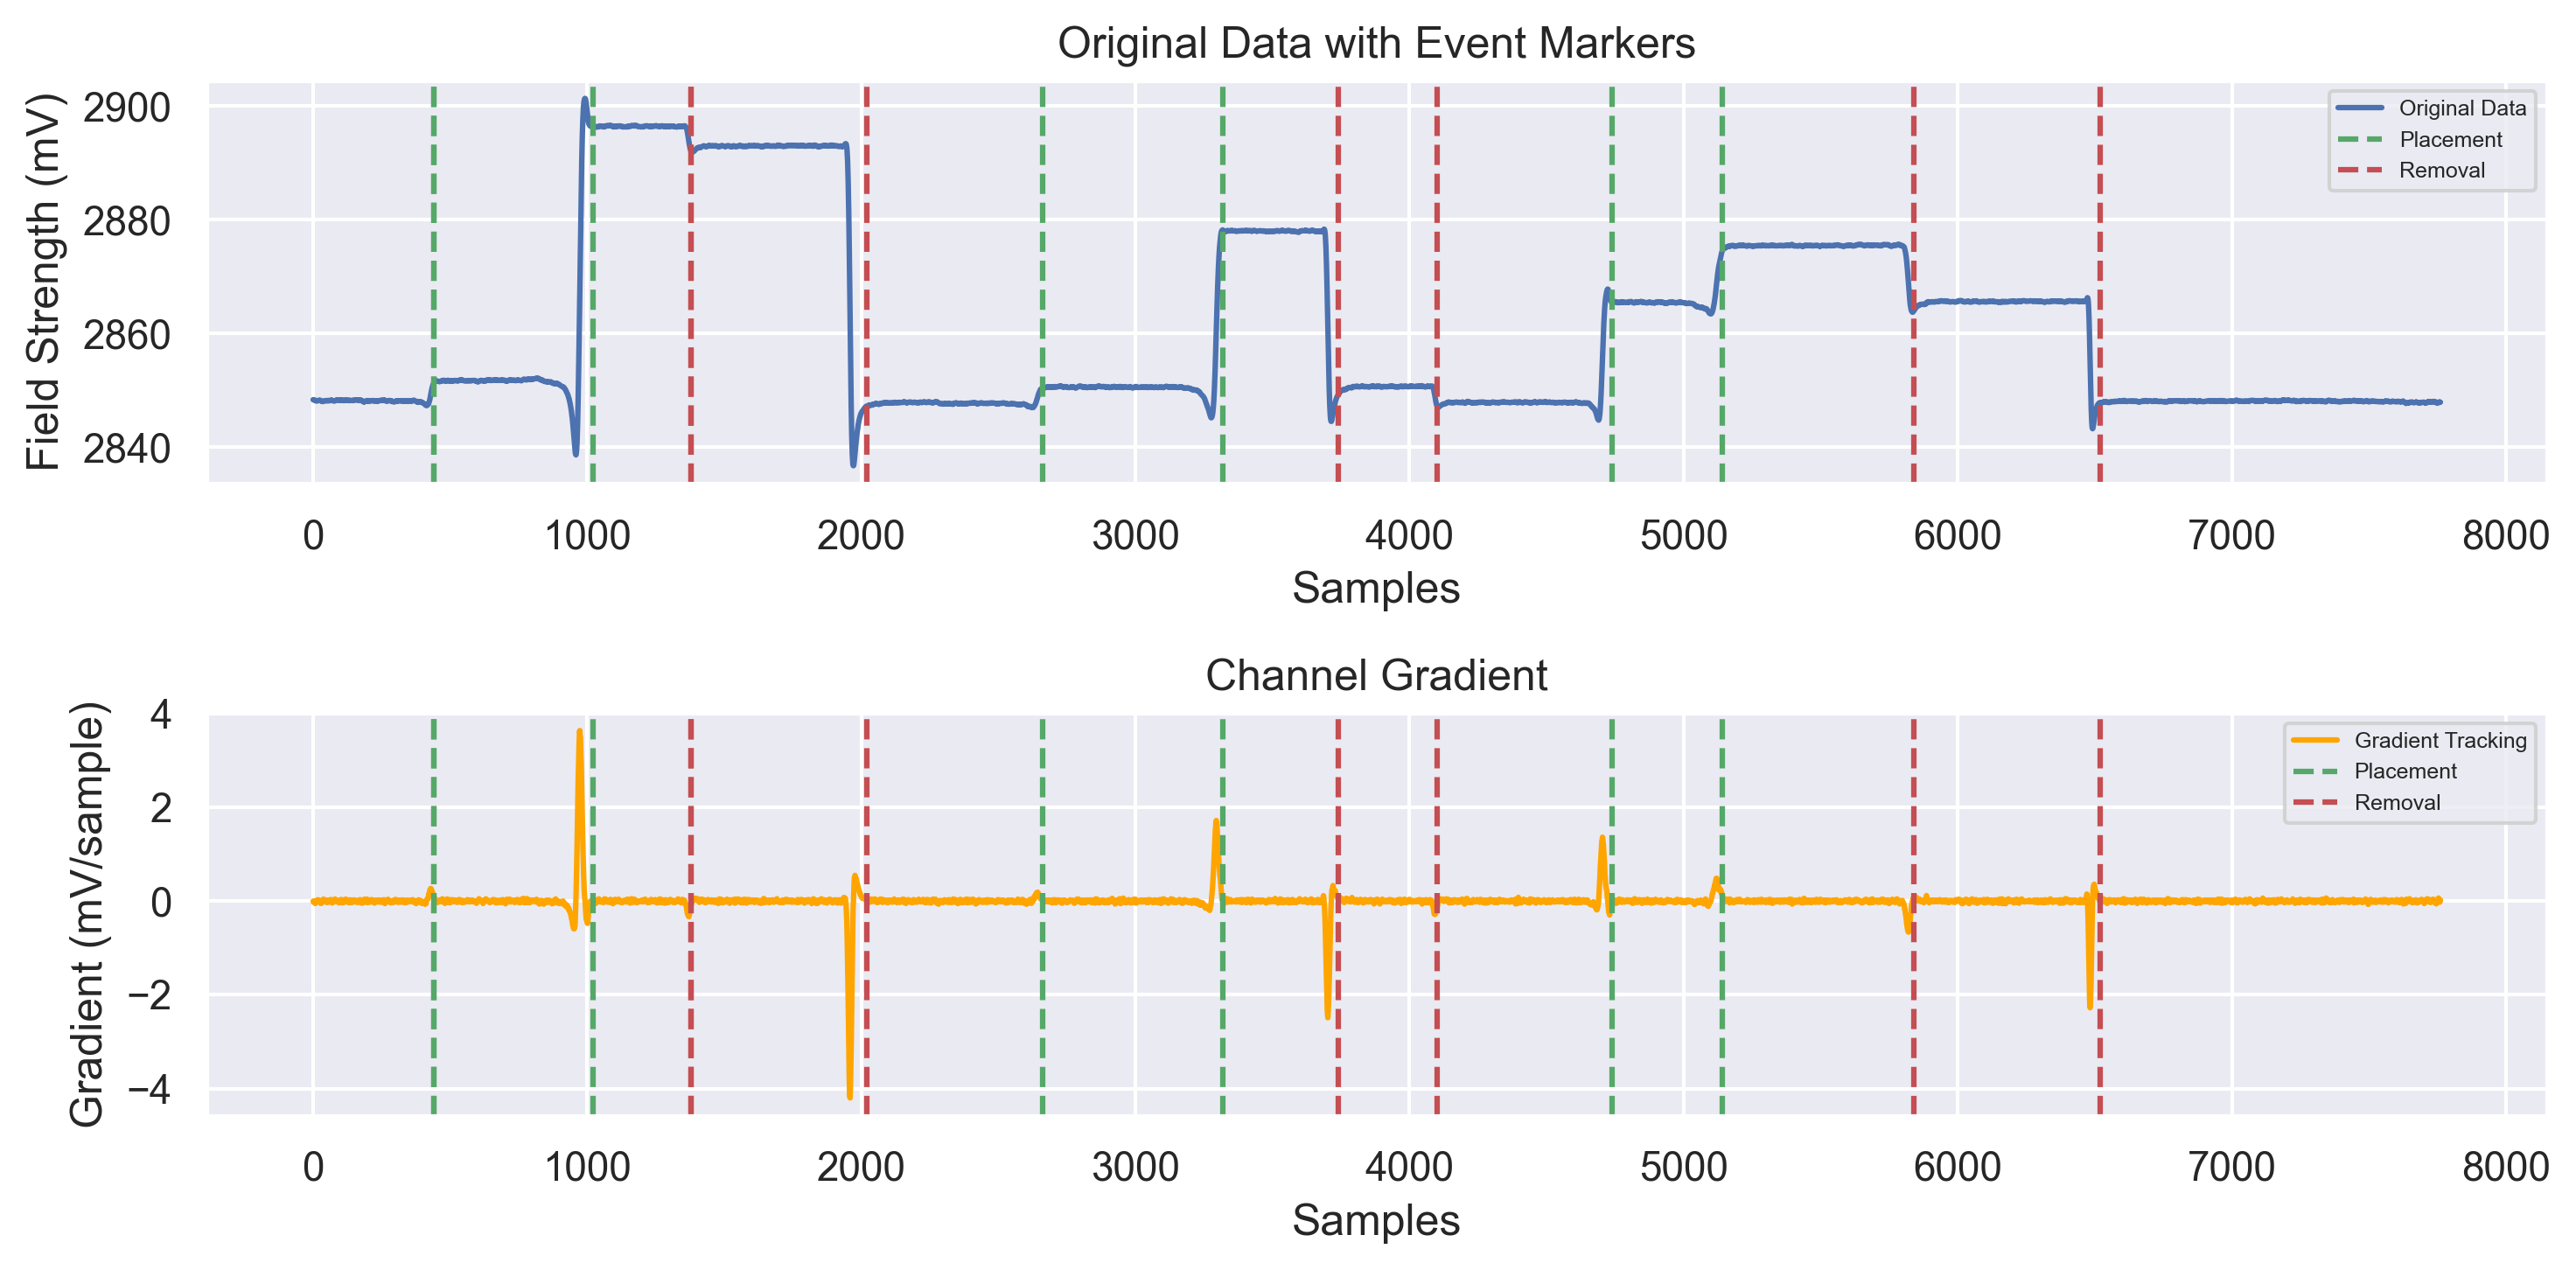

([0,
  320,
  440,
  820,
  1020,
  1280,
  1380,
  1860,
  2020,
  2540,
  2660,
  3140,
  3320,
  3600,
  3740,
  4000,
  4100,
  4580,
  4740,
  5000,
  5140,
  5720,
  5840,
  6380,
  6520],
 [440, 1020, 2660, 3320, 4740, 5140],
 [1380, 2020, 3740, 4100, 5840, 6520],
 {0: 'UNSTABLE --> STABLE',
  320: 'STABLE --> UNSTABLE',
  440: 'UNSTABLE --> STABLE',
  820: 'STABLE --> UNSTABLE',
  1020: 'UNSTABLE --> STABLE',
  1280: 'STABLE --> UNSTABLE',
  1380: 'UNSTABLE --> STABLE',
  1860: 'STABLE --> UNSTABLE',
  2020: 'UNSTABLE --> STABLE',
  2540: 'STABLE --> UNSTABLE',
  2660: 'UNSTABLE --> STABLE',
  3140: 'STABLE --> UNSTABLE',
  3320: 'UNSTABLE --> STABLE',
  3600: 'STABLE --> UNSTABLE',
  3740: 'UNSTABLE --> STABLE',
  4000: 'STABLE --> UNSTABLE',
  4100: 'UNSTABLE --> STABLE',
  4580: 'STABLE --> UNSTABLE',
  4740: 'UNSTABLE --> STABLE',
  5000: 'STABLE --> UNSTABLE',
  5140: 'UNSTABLE --> STABLE',
  5720: 'STABLE --> UNSTABLE',
  5840: 'UNSTABLE --> STABLE',
  6380: 'STABLE --> U

In [ ]:
def place_remove_detect(data_input, window_size=100, threshold_array=np.array([1.05, .95, .85, .75, .65,])):
    # Constants for the number of samples to check and the number of chunks
    num_samples = len(data_input)
    num_chunks = window_size // len(threshold_array)  # Assuming threshold_array length divides window_size
    dict = {}   

    # Initialize arrays to hold the timestamps of various events
    stability_change_stamps = []
    placement_stamps = []
    removal_stamps = []
    some_threshold = 0.7
    stability_mode = False

    # Compute the gradient and replace NaNs with zero
    gradient_values = np.nan_to_num(np.gradient(data_input))
    # Initialize a variable to track the last stable value for comparison
    last_stable_value = None

    # Loop through gradient values in windows of `window_size`
    for indx in range(0, num_samples, num_chunks):
#         print(indx)
        # Define the current window of gradient values
        current_window = gradient_values[indx:indx+window_size]

        # Check if the current window is stable
        if stability_check(current_window, threshold_array, num_chunks):

            # Record the time stamp for when the system becomes stable
            if not stability_mode:
                stability_mode = True
                stability_change_stamps.append(indx)
                dict[indx] = "UNSTABLE --> STABLE"
                # print("system goes from UNSTABLE into STABLE")

            # Check for placement or removal only if the last stable value is available
            if last_stable_value is not None:
                current_stable_value = np.mean(data_input[indx:indx+window_size])
                
                # Check if there is a significant increase (placement)
                if current_stable_value > last_stable_value + some_threshold:
                    placement_stamps.append(indx)

                # Check if there is a significant decrease (removal)
                elif current_stable_value < last_stable_value - some_threshold:
                    removal_stamps.append(indx)

            # Update the last stable value
            last_stable_value = np.mean(data_input[indx:indx+window_size])

        else:

            # Record when the system leaves stability, if it was previously stable
            if stability_mode:
                stability_mode = False
                stability_change_stamps.append(indx)
                dict[indx] = "STABLE --> UNSTABLE"
                # print("system goes from STABLE into UNSTABLE")

    
    formatter = ScalarFormatter(useOffset=False)

    # Set up subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), dpi=300)

     # Plot original data with placement and removal stamps
    axs[0].plot(data_input, label='Original Data')
    
    # Initialize the legend handled dictionaries
    legend_handles = {'Placement': False, 'Removal': False}

    for stamp in placement_stamps:
        axs[0].axvline(x=stamp, color='g', linestyle='--')
        if not legend_handles['Placement']:
            axs[0].axvline(x=stamp, color='g', linestyle='--', label='Placement')
            legend_handles['Placement'] = True

    for stamp in removal_stamps:
        axs[0].axvline(x=stamp, color='r', linestyle='--')
        if not legend_handles['Removal']:
            axs[0].axvline(x=stamp, color='r', linestyle='--', label='Removal')
            legend_handles['Removal'] = True

    axs[0].set_title('Original Data with Event Markers')
    axs[0].set_xlabel('Samples')
    axs[0].set_ylabel('Field Strength (mV)')
    axs[0].xaxis.set_major_formatter(formatter)
    axs[0].yaxis.set_major_formatter(formatter)
    axs[0].legend(loc="upper right", prop={'size': 6})

    # Plot channel gradient and mark peaks based on correlation
    axs[1].plot(gradient_values, label="Gradient Tracking", color="orange")

    legend_handles = {'Placement': False, 'Removal': False}

    for stamp in placement_stamps:
        axs[1].axvline(x=stamp, color='g', linestyle='--')
        if not legend_handles['Placement']:
            axs[1].axvline(x=stamp, color='g', linestyle='--', label='Placement')
            legend_handles['Placement'] = True

    for stamp in removal_stamps:
        axs[1].axvline(x=stamp, color='r', linestyle='--')
        if not legend_handles['Removal']:
            axs[1].axvline(x=stamp, color='r', linestyle='--', label='Removal')
            legend_handles['Removal'] = True

    axs[1].set_title(f'Channel Gradient')
    axs[1].set_xlabel('Samples')
    axs[1].set_ylabel('Gradient (mV/sample)')
    axs[1].xaxis.set_major_formatter(formatter)
    axs[1].yaxis.set_major_formatter(formatter)
    axs[1].legend(loc="upper right", prop={'size': 6})

    plt.tight_layout()
    plt.show()

#     print(len(dict))

    return stability_change_stamps, placement_stamps, removal_stamps, dict


raw_df_cur = pd.read_csv("./.../data/feb-12-PRM-and-PRMM-place-remove-3-times.txt", names=["anchor_0", "anchor_1", "anchor_2"])

place_remove_detect(raw_df_cur["anchor_0"])

In [ ]:
def compute_mse(data):
    # Calculate the ad-hoc sampling frequency
    data_len = data.shape[0]
    adhoc_fs = data_len / 53.0

    # Compute base chunk mean values
    base_chunk = data[0:int(4 * adhoc_fs), :]
    base_mean = np.mean(base_chunk, axis=0)

    # Initialize MSE results list with base mean values
    results = {'base': base_mean}

    # Define the positions chunks
    positions = [(5, 9), (15, 19), (25, 29), (35, 39)]

    # Loop through positions to compute mean and MSE
    for i, (start, end) in enumerate(positions, start=1):
        chunk = data[int(start * adhoc_fs):int(end * adhoc_fs), :]
        chunk_mean = np.mean(chunk, axis=0)
        mse = np.mean((chunk_mean - base_mean) ** 2)
        results[f'mse_p{i}'] = mse

    return results

# Example usage
# Assuming `data` is a numpy array of shape [data_len, 5]
# data = np.random.rand(1000, 5)  # Example data, replace with actual data
# results = compute_mse(data)
# print(results)

In [36]:
import os

# Define the directory containing the CSV files
directory = "../data/mar-21-comparison-among-soln-types"

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the file is a CSV
    if filename.endswith(".csv"):
        # Construct the full path to the file
        filepath = os.path.join(directory, filename)
        
        # Read the CSV file using pandas
        data = pd.read_csv(filepath).values  # Convert DataFrame to NumPy array for the function
        
        # Call the previously defined function to compute the MSE
        results = compute_mse(data)
        
        # Print the filename and the corresponding results
        print(f"Filename: {filename}, Results: {results}")

In [37]:
raw_df_prlm_x_12_5_y_30 = pd.read_csv("./../data/apr-4-prlm-localisation-data-each-position/apr-4-prlm-place-x=12-5-y=30__5-times.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])

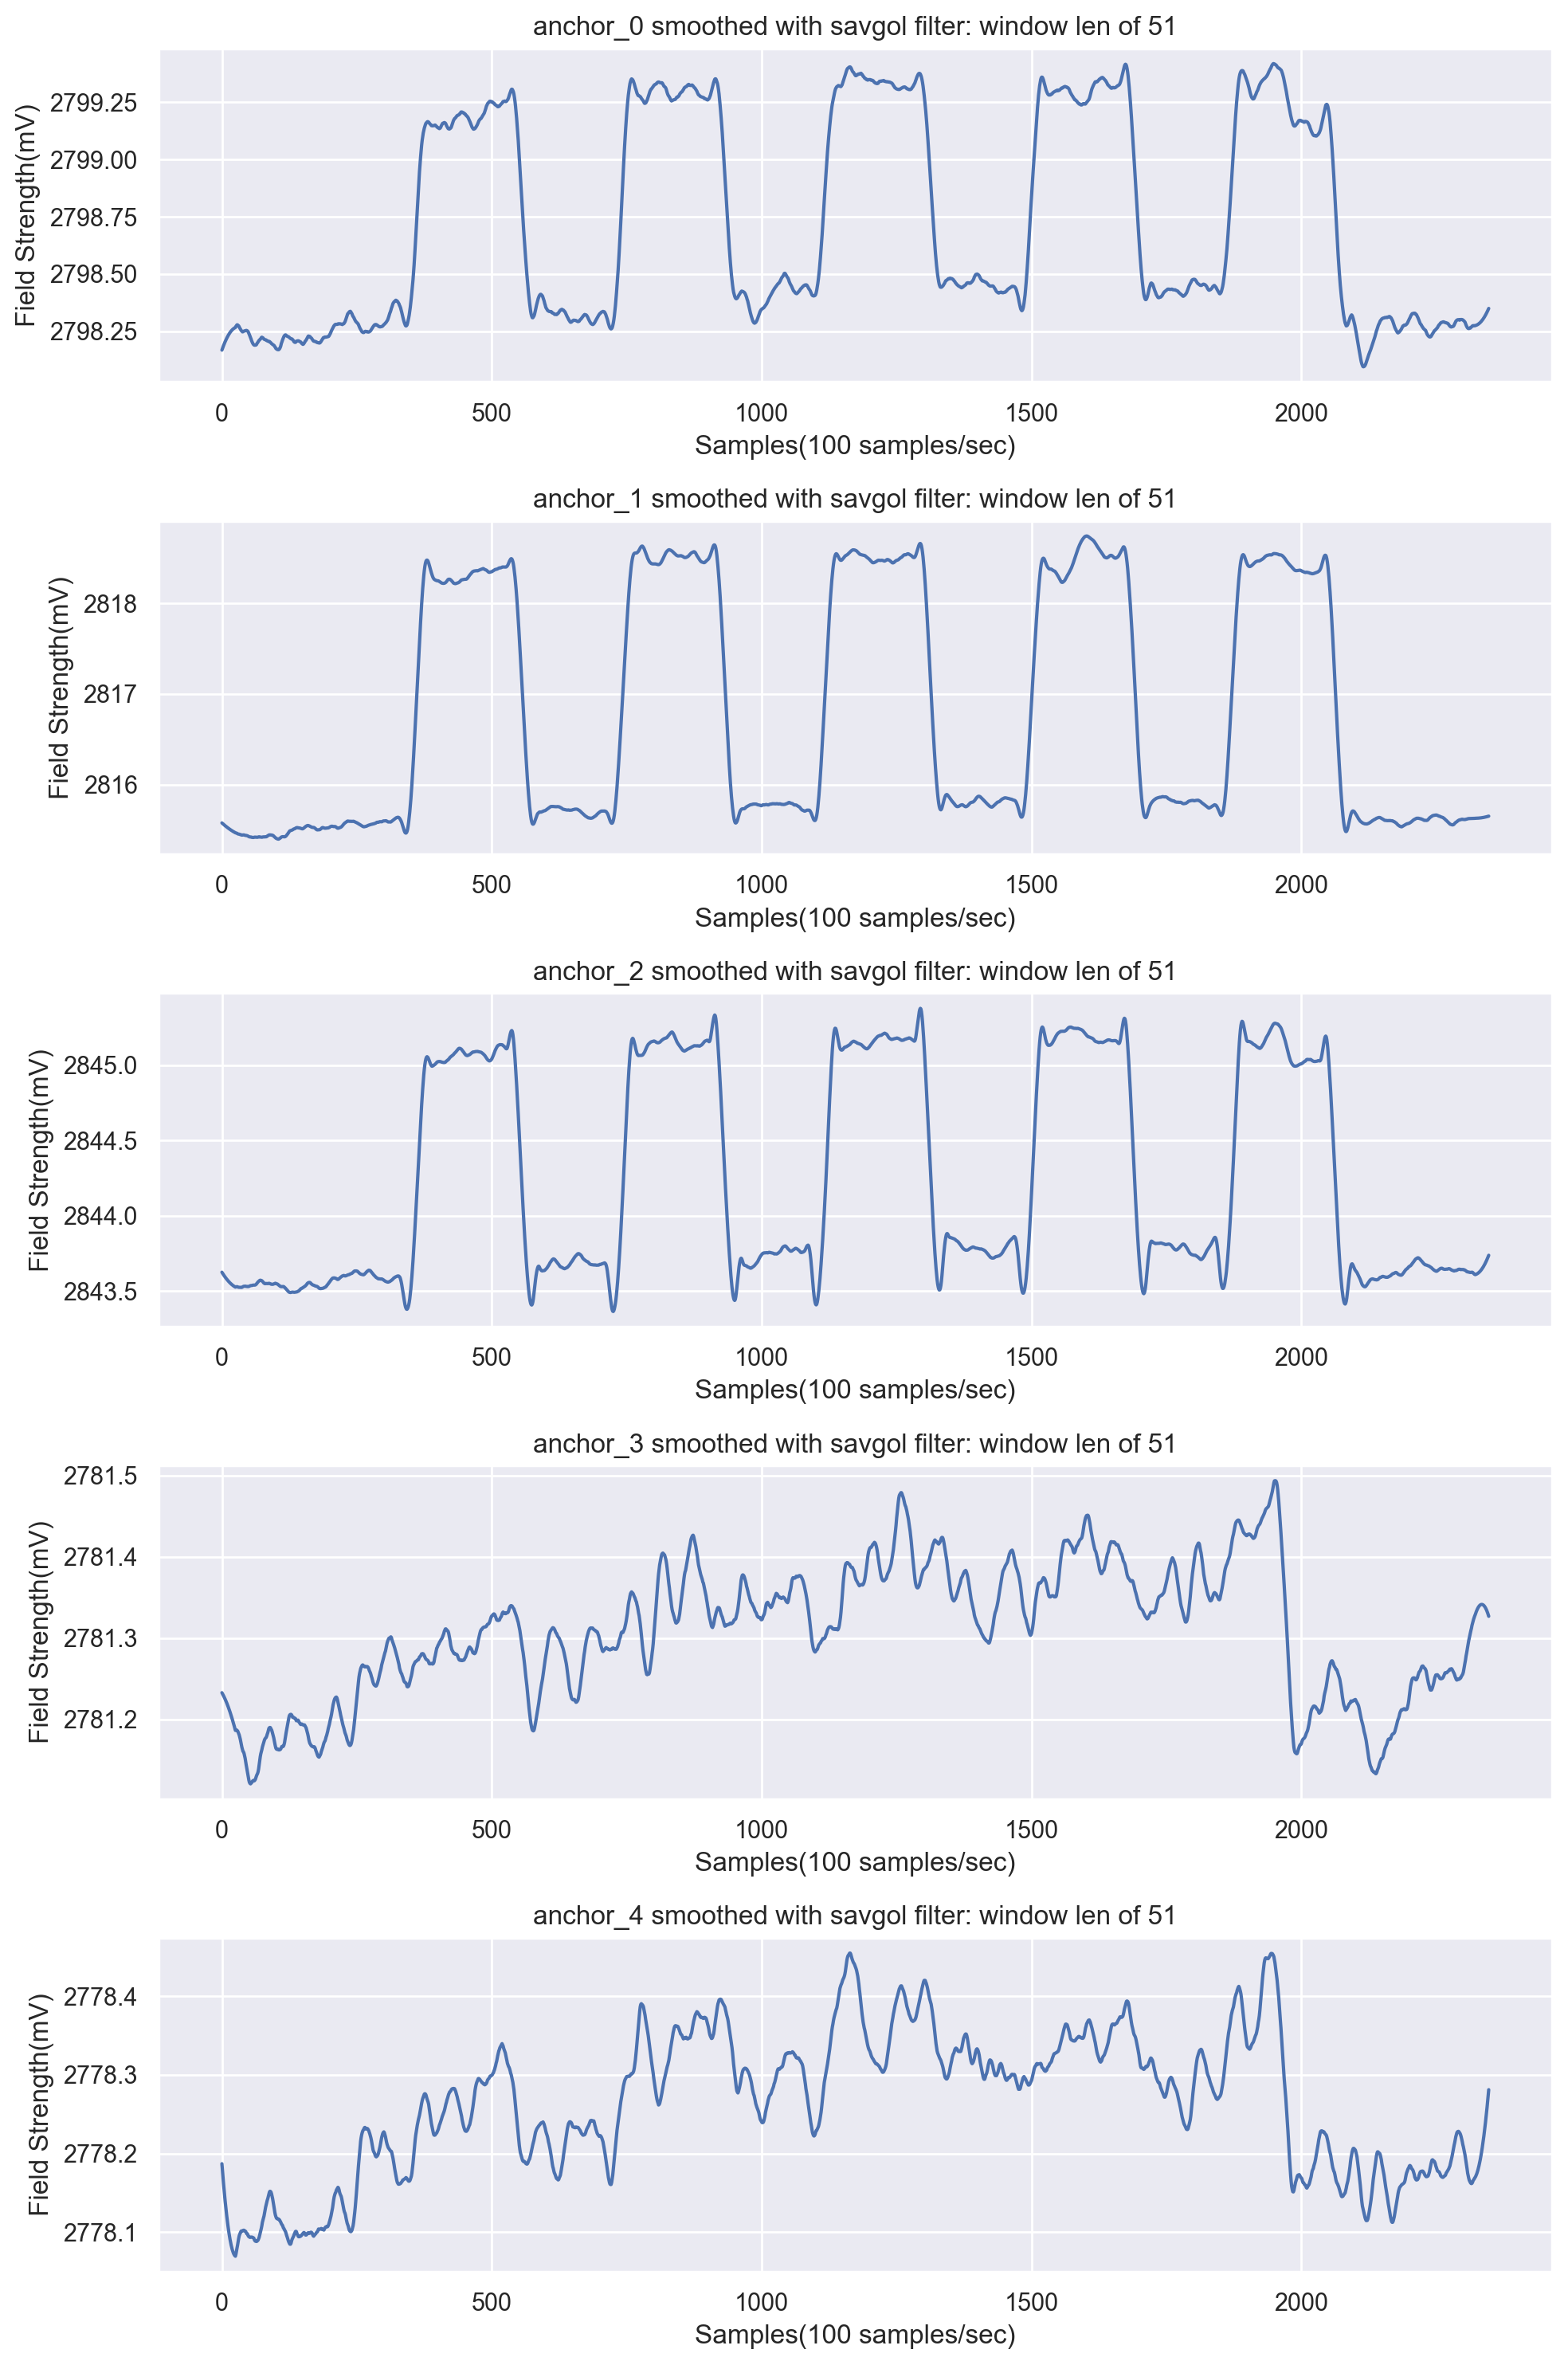

In [38]:
plot_3_channels(raw_df=raw_df_prlm_x_12_5_y_30, no_of_anchors_to_plot=5, filtering=True)

### Flexible Stability Check Function

This function, `stability_check`, is designed to assess the stability of a data stream using multiple methods. It segments the data into chunks and applies a stability criterion to each chunk. The function can be configured to use different methods for determining stability, making it versatile for various data types and scenarios.

#### Function Details:

- **Parameters**:
  - `data`: The data array to be analyzed.
  - `thresholds`: Thresholds against which stability is checked.
  - `method`: The method used to determine stability ('std' for standard deviation, 'intuition' for zero-mean deviation).
  - `num_chunks`: Number of chunks to divide the data into.
  - `chunk_size`: Number of data points per chunk.

#### Stability Methods:

- **Standard Deviation (`'std'`)**: Checks if the standard deviation of each chunk is below a certain threshold, indicating low variability and hence stability.

- **Intuitive Zero-mean Deviation (`'intuition'`)**: Applies a zero-mean transformation to each chunk and calculates the mean absolute deviation from zero. This method is useful for data where the mean itself may not be stable but relative changes are of interest.

The function returns `True` if all chunks are considered stable according to the selected method and thresholds, otherwise `False`.

#### Example Usage:

```python
# Example data array
data = np.random.randn(100) * 5 + 50

# Thresholds for stability check
thresholds = [0.5] * 5  # Five chunks with a threshold of 0.5

# Using standard deviation method
is_stable_std = stability_check(data, thresholds, method='std', num_chunks=5, chunk_size=20)

# Using intuitive zero-mean deviation method
is_stable_intuition = stability_check(data, thresholds, method='intuition', num_chunks=5, chunk_size=20)

print(f"Stability (std method): {is_stable_std}")
print(f"Stability (intuition method): {is_stable_intuition}")


In [ ]:
def stability_check(data, thresholds, method='intuition', num_chunks=5, chunk_size=10):
    # Check the selected method and apply the appropriate stability analysis
#     print(f"the method used in stability check func: {method}")

#     if method == 'gradient':
#         # Method 1: 1st Derivative Check
#         summed_deri = []
#         for i in range(num_chunks):
#             chunk = data[i * chunk_size:i * chunk_size + chunk_size]
#             abs_derivatives = np.abs(chunk)
#             sum_derivatives = np.mean(abs_derivatives)
#             summed_deri.append(sum_derivatives)
#         return np.all(np.array(summed_deri) <= thresholds)

    if method == 'std':
        # Method 2: Standard Deviation Check
        std_values = []
        for i in range(num_chunks):
            chunk = data[i * chunk_size:i * chunk_size + chunk_size]
            std_dev = np.std(chunk)
            std_values.append(std_dev)
#         print(std_values)
#         print(np.all(np.array(std_values) <= thresholds))
        return np.all(np.array(std_values) <= thresholds)

    elif method == 'intuition':
        # Method 3: Adjusted Percentile-based Check (Zero-mean average deviation check)
        deviations = []
        for i in range(num_chunks):
            chunk = data[i * chunk_size:(i + 1) * chunk_size]
            # Zero-mean the chunk
            chunk_zero_meaned = chunk - np.mean(chunk)
            # Calculate the average of the zero-meaned values (essentially the average deviation from the mean)
            avg_deviation = np.mean(np.abs(chunk_zero_meaned))
            deviations.append(avg_deviation)

        # Compare each chunk's average deviation to the corresponding threshold
        stability_result = np.all(np.array(deviations) <= thresholds)
#         print(stability_result)
        return stability_result

    else:
        raise ValueError("Unknown method specified. Use 'gradient', 'std', or 'percentile'.")


In [ ]:
def calculate_thresholds(baseline_data, chunk_size, method='intuition', data_type="raw"):
    if data_type=="1st_derivative":
        baseline_data = np.nan_to_num(np.gradient(baseline_data))
    elif data_type=="2nd_derivative":
        baseine_data = np.nan_to_num(np.gradient(np.gradient(baseline_data)))
        
    num_chunks = len(baseline_data) // chunk_size
    measure_func = lambda chunk: np.percentile(chunk, 99.5) - np.mean(chunk)
    chunk_measures = [measure_func(baseline_data[i*chunk_size:(i+1)*chunk_size]) for i in range(num_chunks)]
    avg_threshold = np.mean(chunk_measures)
    return avg_threshold

def place_remove_detect(data_input, window_size=50, threshold_array_len=5, method='intuition', threshold_multipliers=None, data_type="raw"):
    num_samples = len(data_input)
    baseline_data = data_input[:300]
    chunk_size = window_size // threshold_array_len
    threshold = calculate_thresholds(baseline_data, chunk_size, "intuition", data_type)
    
    if threshold_multipliers is None:
        threshold_multipliers = np.ones(threshold_array_len)  # Default to all ones if none provided
    
    thresholds = threshold * np.array(threshold_multipliers)
    
    stability_change_stamps = []
    placement_stamps = []
    removal_stamps = []
    some_threshold = 0.7
    stability_mode = False
    stability_dict = {}
    
    first_deri = np.nan_to_num(np.gradient(data_input))
    second_deri = np.nan_to_num(np.gradient(first_deri))
    processed_data = data_input
    
    if data_type == "1st_derivative":
        processed_data = first_deri
    elif data_type == "2nd_derivative":
        processed_data = second_deri

    last_stable_value = None

    # Loop through the processed data in windows of `window_size`
    for indx in range(0, num_samples, window_size // threshold_array_len):
#         print(indx)
        if indx + window_size > num_samples:
            continue  # Avoid indexing beyond the end of the array
        current_window = processed_data[indx:indx + window_size]

        if stability_check(current_window, thresholds, method=method):
            if not stability_mode:
                stability_mode = True
                stability_change_stamps.append(indx)
                stability_dict[indx] = "UNSTABLE --> STABLE"

            if last_stable_value is not None:
                current_stable_value = np.mean(data_input[indx:indx + window_size])
                if current_stable_value > last_stable_value + some_threshold:
                    placement_stamps.append(indx)
                elif current_stable_value < last_stable_value - some_threshold:
                    removal_stamps.append(indx)

            last_stable_value = np.mean(data_input[indx:indx + window_size])
        else:
            if stability_mode:
                stability_mode = False
                stability_change_stamps.append(indx)
                stability_dict[indx] = "STABLE --> UNSTABLE"
                
                
                
    
    # Plotting logic
    fig, axs = plt.subplots(3, 1, figsize=(10, 7), dpi=300)
    axs[0].plot(data_input, label='Original Data')

    for stamp in placement_stamps:
        axs[0].axvline(x=stamp, color='g', linestyle='--', label=f'{method}*{threshold_multipliers} Place' if stamp == placement_stamps[0] else "")
    for stamp in removal_stamps:
        axs[0].axvline(x=stamp, color='r', linestyle='--', label=f'{method}*{threshold_multipliers} Remove' if stamp == removal_stamps[0] else "")

    

    axs[1].plot(first_deri, label='1st Derivative Tracking', color='orange')

    for stamp in placement_stamps:
        axs[1].axvline(x=stamp, color='g', linestyle='--', label=f'{method}*{threshold_multipliers} Place' if stamp == placement_stamps[0] else "")
    for stamp in removal_stamps:
        axs[1].axvline(x=stamp, color='r', linestyle='--', label=f'{method}*{threshold_multipliers} Remove' if stamp == removal_stamps[0] else "")

    axs[2].plot(second_deri, label='2nd Derivative Tracking', color='purple')

    for stamp in placement_stamps:
        axs[2].axvline(x=stamp, color='g', linestyle='--', label=f'{method}*{threshold_multipliers} Place' if stamp == placement_stamps[0] else "")
    for stamp in removal_stamps:
        axs[2].axvline(x=stamp, color='r', linestyle='--', label=f'{method}*{threshold_multipliers} Remove' if stamp == removal_stamps[0] else "")


        
        
    
#     print(processed_data)
    
    if data_type=="raw":
        axs[0].axvspan(0, 300, color='black', alpha=0.3, label='Training Data')
    elif data_type == "1st_derivative":
        axs[1].axvspan(0, 300, color='black', alpha=0.3, label='Training Data')
    else:
        axs[2].axvspan(0, 300, color='black', alpha=0.3, label='Training Data')


    axs[0].set_title('Original Data with Event Markers')
    axs[0].set_xlabel('Samples')
    axs[0].set_ylabel('Field Strength (mV)')
    axs[0].legend(loc="upper right", fontsize=6)
    
    axs[1].set_title('Channel 1st Derivative')
    axs[1].set_xlabel('Samples')
    axs[1].set_ylabel('Gradient (mV/sample)')
    axs[1].legend(loc="upper right", fontsize=6)
    
    axs[2].set_title('Channel 2nd Derivative')
    axs[2].set_xlabel('Samples')
    axs[2].set_ylabel('2nd order Gradient (mV/sample^2)')
    axs[2].legend(loc="upper right", fontsize=6)

    plt.tight_layout()
    plt.show()
    
    print(thresholds)
    print(f"stability dict is as follows: {stability_dict}")
    print(f"In total we have {len(stability_dict)} number of stability changes")

    return stability_change_stamps, placement_stamps, removal_stamps, stability_dict

In [ ]:
def calculate_thresholds(baseline_data, chunk_size, data_type="raw"):
        
    measure_func = lambda chunk: np.percentile(chunk, 99.5) - np.mean(chunk)
    num_chunks = len(baseline_data) // chunk_size
    chunk_measures = [measure_func(baseline_data[i*chunk_size:(i+1)*chunk_size]) for i in range(num_chunks)]
    avg_threshold = np.mean(chunk_measures)
    return avg_threshold

def stability_check(data, thresholds, num_chunks=5, chunk_size=10, method='intuition',):

    if method == 'std':
        # Method 2: Standard Deviation Check
        std_values = []
        for i in range(num_chunks):
            chunk = data[i * chunk_size:i * chunk_size + chunk_size]
            std_dev = np.std(chunk)
            std_values.append(std_dev)
#         print(std_values)
#         print(np.all(np.array(std_values) <= thresholds))
        return np.all(np.array(std_values) <= thresholds)

    elif method == 'intuition':
        # Method 3: Adjusted Percentile-based Check (Zero-mean average deviation check)
        deviations = []
        for i in range(num_chunks):
            chunk = data[i * chunk_size:(i + 1) * chunk_size]
            # Zero-mean the chunk
            chunk_zero_meaned = chunk - np.mean(chunk)
            # Calculate the average of the zero-meaned values (essentially the average deviation from the mean)
            avg_deviation = np.mean(np.abs(chunk_zero_meaned))
            deviations.append(avg_deviation)

        # Compare each chunk's average deviation to the corresponding threshold
        stability_result = np.all(np.array(deviations) <= thresholds)
#         print(stability_result)
        return stability_result

    else:
        raise ValueError("Unknown method specified. Use 'gradient', 'std', or 'percentile'.")

def place_remove_detect(data_input, window_size=50, threshold_array_len=5, method='intuition', threshold_multipliers=None):
    num_samples = len(data_input)
    chunk_size = window_size // threshold_array_len
    data_types = ['Raw', '1st_derivative', '2nd_derivative']
    processed_data_list = [data_input, np.nan_to_num(np.gradient(data_input)), np.nan_to_num(np.gradient(np.gradient(data_input)))]
    results = {}
    thresholds = np.array([calculate_thresholds(processed_data_list[0][:180], chunk_size, data_type="raw") * np.array(threshold_multipliers),
                           calculate_thresholds(processed_data_list[1][:180], chunk_size, data_type="1st_derivative") * np.array(threshold_multipliers),
                           calculate_thresholds(processed_data_list[2][:180], chunk_size, data_type="2nd_derivative") * np.array(threshold_multipliers)])
    if threshold_multipliers is None:
        threshold_multipliers = np.ones(threshold_array_len)  # Default to all ones if none provided
    some_threshold = .7

    

    fig, axs = plt.subplots(3, 1, figsize=(12, 9), dpi=300)

    for i, (data_type, processed_data) in enumerate(zip(data_types, processed_data_list)):
        stability_change_stamps = []
        placement_stamps = []
        removal_stamps = []
        stability_mode = False
        stability_dict = {}
        last_stable_value = None

    # Loop through the processed data in windows of `window_size`
        for indx in range(0, num_samples, window_size // threshold_array_len):
    #         print(indx)
            if indx + window_size > num_samples:
                continue  # Avoid indexing beyond the end of the array
            current_window = processed_data[indx:indx + window_size]

            if stability_check(current_window, thresholds[i], method=method):
                if not stability_mode:
                    stability_mode = True
                    stability_change_stamps.append(indx)
                    stability_dict[indx] = "UNSTABLE --> STABLE"

                if last_stable_value is not None:
                    current_stable_value = np.mean(data_input[indx:indx + window_size])
                    if current_stable_value > last_stable_value + some_threshold:
                        placement_stamps.append(indx)
                    elif current_stable_value < last_stable_value - some_threshold:
                        removal_stamps.append(indx)

                last_stable_value = np.mean(data_input[indx:indx + window_size])
            else:
                if stability_mode:
                    stability_mode = False
                    stability_change_stamps.append(indx)
                    stability_dict[indx] = "STABLE --> UNSTABLE"

        

        axs[i].plot(processed_data, label=f'{data_type} Data', color='royalblue' if i==0 else 'orange' if i==1 else 'mediumpurple')
        for stamp in placement_stamps:
            axs[i].axvline(x=stamp, color='g', linestyle='--', label=f'Place' if stamp == placement_stamps[0] else "")
        for stamp in removal_stamps:
            axs[i].axvline(x=stamp, color='r', linestyle='--', label=f'Remove' if stamp == removal_stamps[0] else "")

        axs[i].axvspan(0, 180, color='grey', alpha=0.3, label='Baseline Data')
        axs[i].set_title(f'{method} on {data_type} Data with {threshold_multipliers} * zero-meaned 99.5% percentile')
        axs[i].set_xlabel('Samples')
        axs[i].set_ylabel(f'{data_type} Values')
        axs[i].legend(loc="upper right", fontsize=7)
        
#         print(placement_stamps)
#         print(removal_stamps)
    print(f"thresholds arrays are as follows: {thresholds}")

    plt.tight_layout()
    plt.show()
    
    

    return results  # You can decide how to structure this based on what you want to return


thresholds arrays are as follows: [[0.17732393 0.17329384 0.16926375 0.16523366 0.16120357]
 [0.05148744 0.05031727 0.0491471  0.04797693 0.04680676]
 [0.02519242 0.02461986 0.02404731 0.02347475 0.0229022 ]]


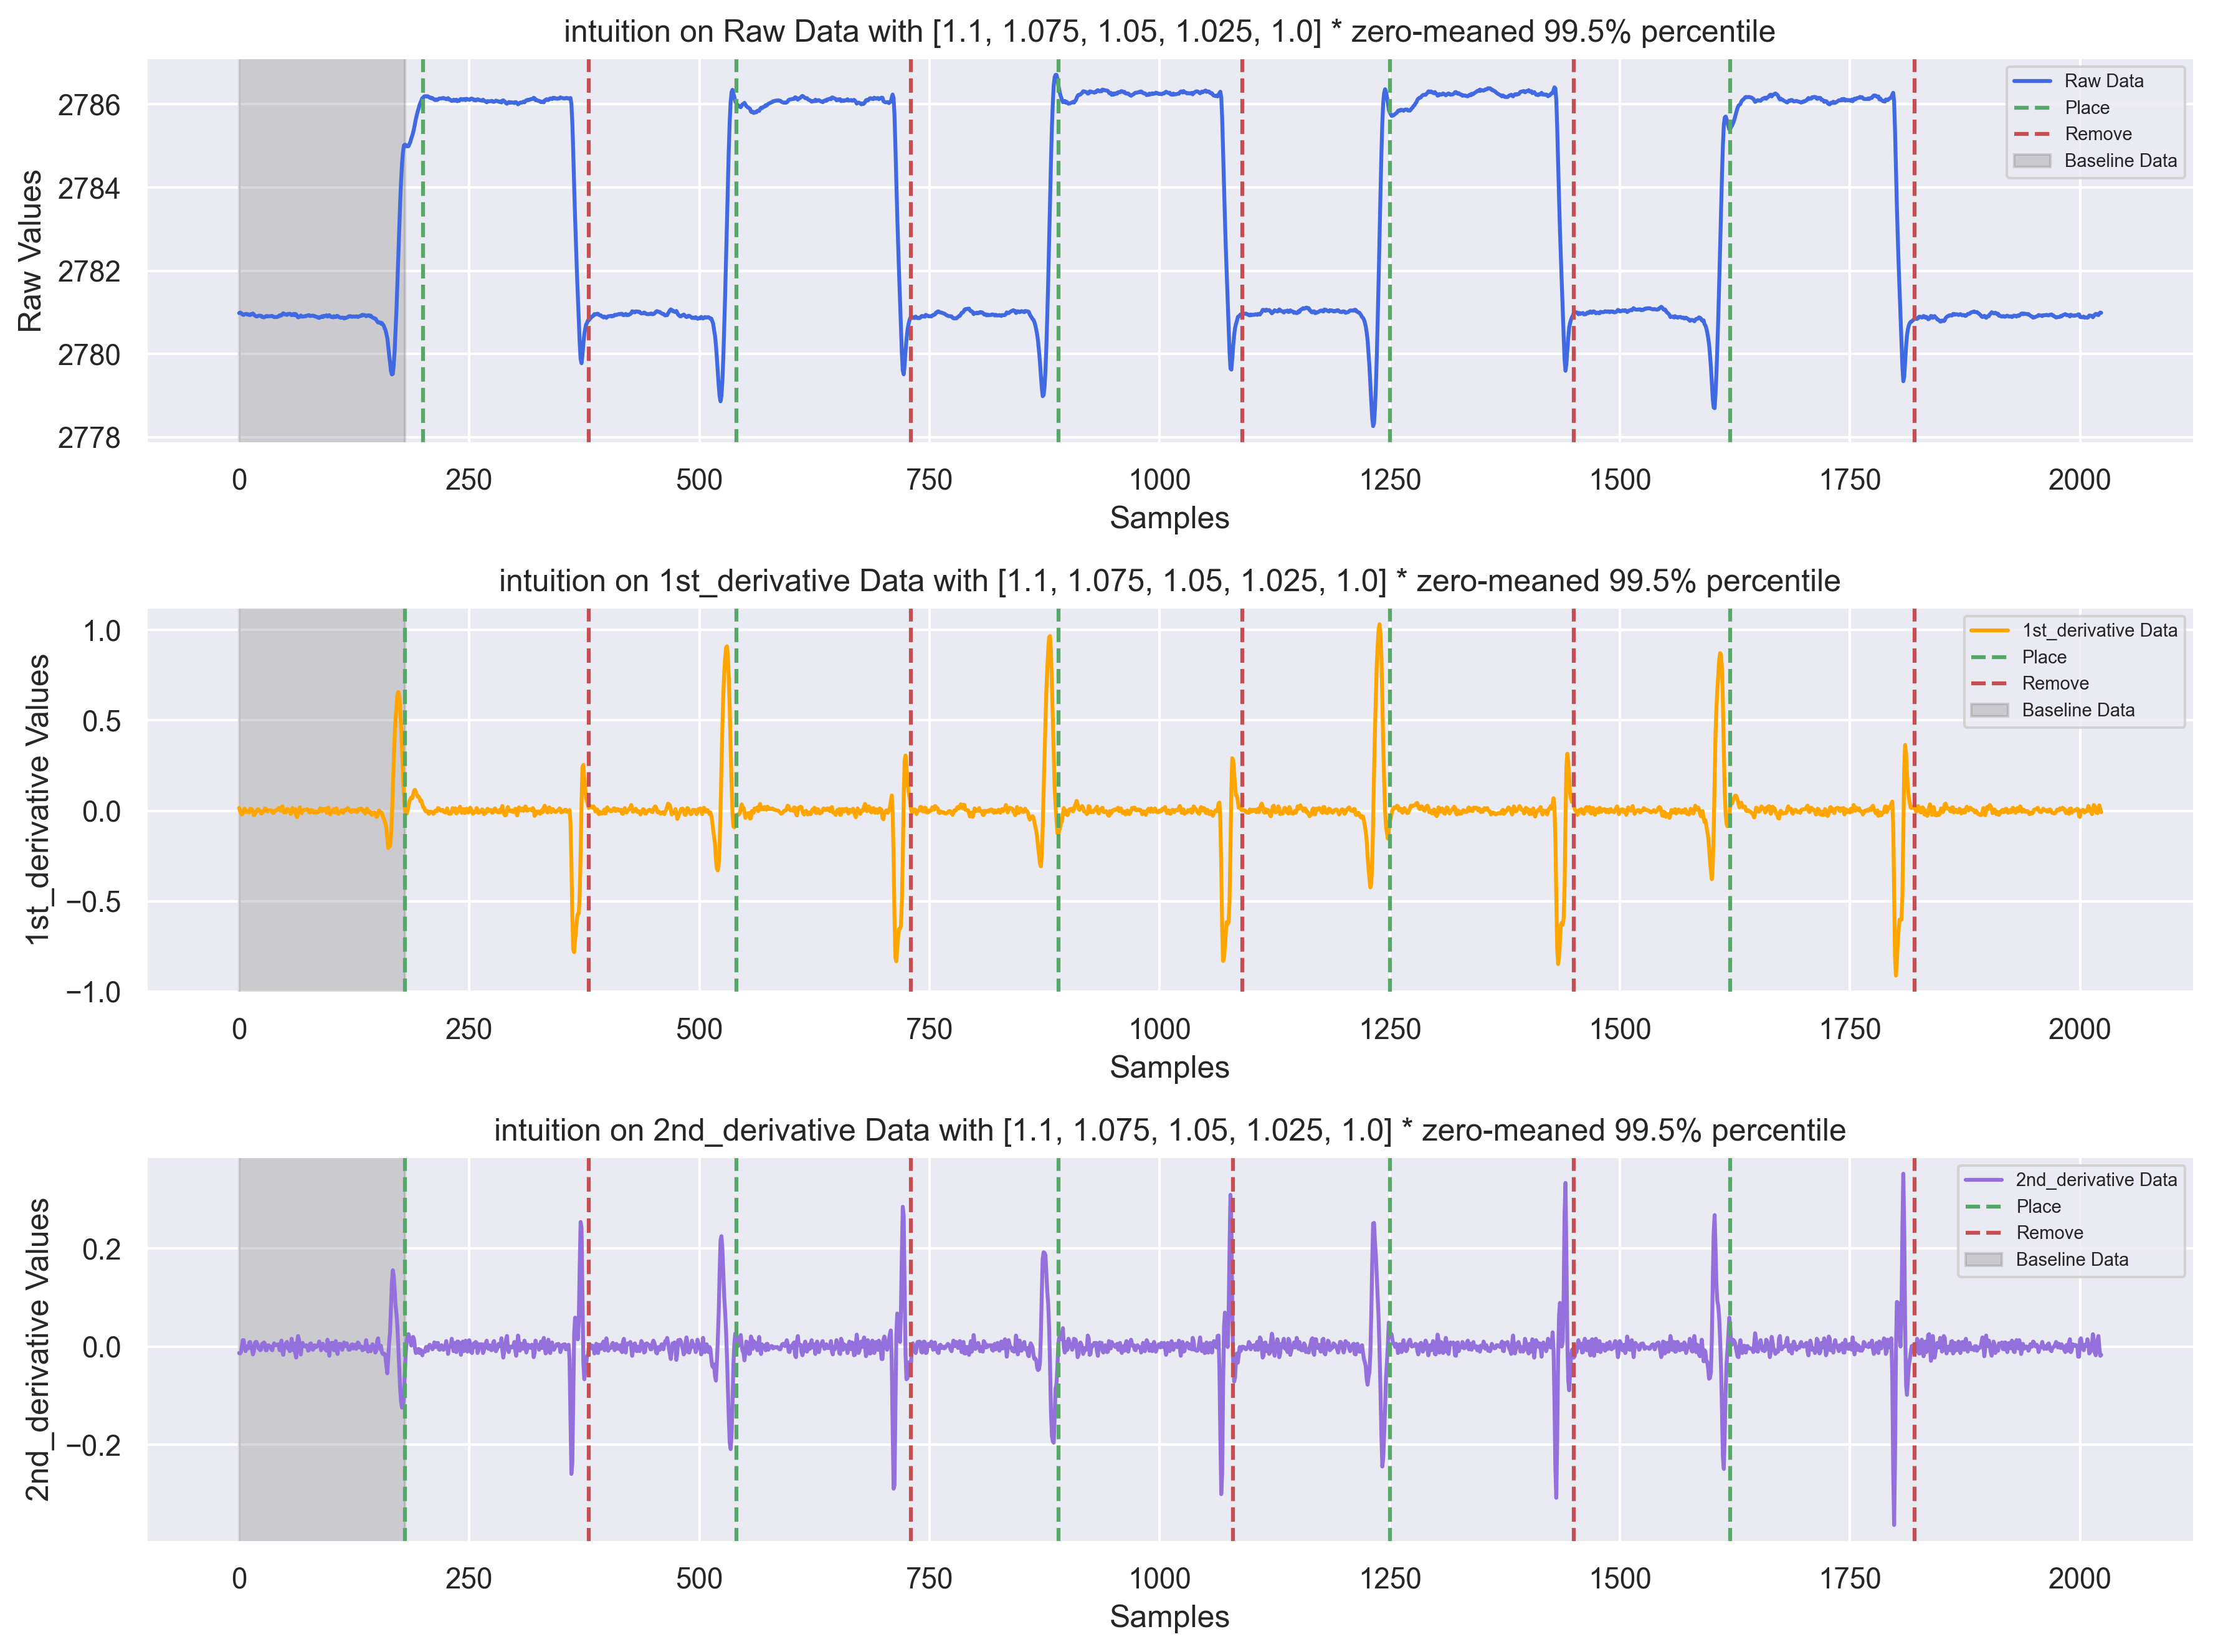

thresholds arrays are as follows: [[0.17732393 0.17329384 0.16926375 0.16523366 0.16120357]
 [0.05148744 0.05031727 0.0491471  0.04797693 0.04680676]
 [0.02519242 0.02461986 0.02404731 0.02347475 0.0229022 ]]


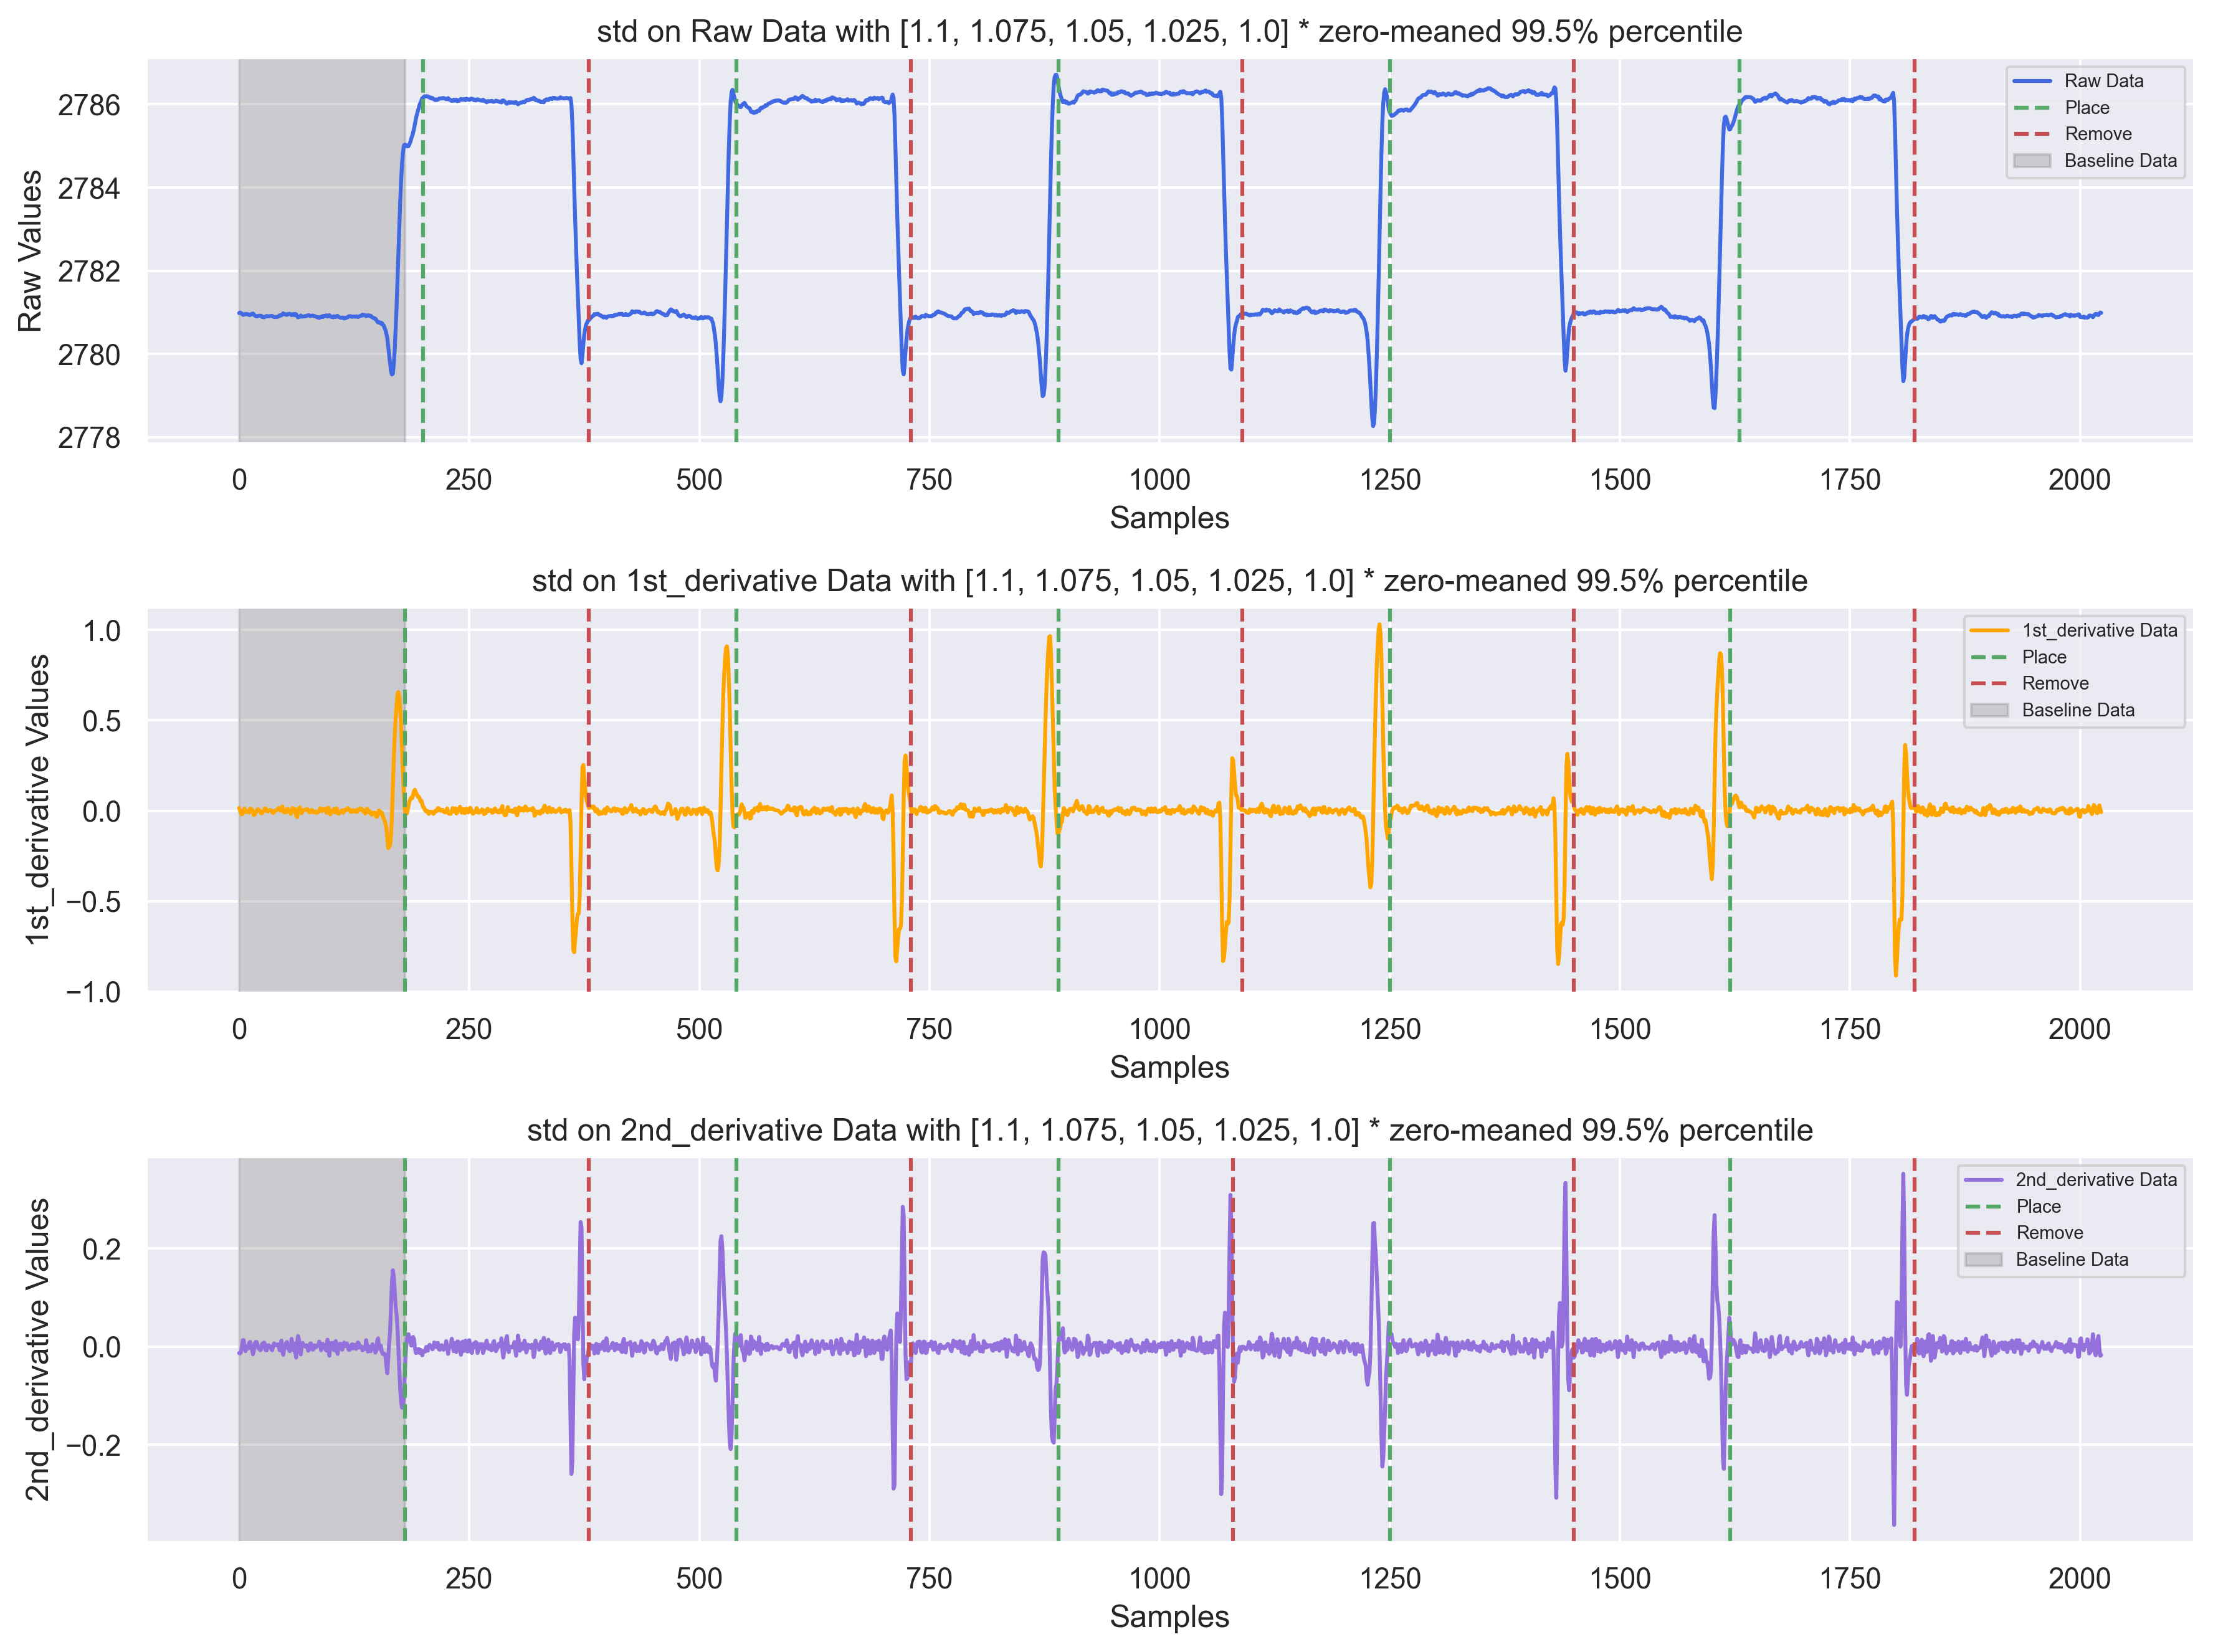

In [ ]:

test_df = pd.read_csv("./.../data/apr-4-prlm-localisation-data-each-position/apr-4-prlm-place-x=57-5-y=00__5-times.txt", names=["anchor_0", "anchor_1", "anchor_2", "anchor_3", "anchor_4"])




x = place_remove_detect(test_df["anchor_3"], method="intuition", threshold_multipliers=[1.1, 1.075, 1.05, 1.025, 1.])


x = place_remove_detect(test_df["anchor_3"], method="std", threshold_multipliers=[1.1, 1.075, 1.05, 1.025, 1.])


### Noise Distribution Analysis

This section of the code is utilized to analyze the noise distribution in a given dataset to ensure it follows a Gaussian distribution. This is crucial in many statistical analyses where the assumption of normality underpins the validity of inferential statistics.

#### Detailed Explanation:

- **Data Selection**:
  - Here, a specific segment of the data (`data = raw_df_prlm_x_12_5_y_30["anchor_0"][:300]`) is selected. Ensure to replace `raw_df_prlm_x_12_5_y_30["anchor_0"]` with your actual data source and slice accordingly.

- **Statistical Analysis**:
  - The mean (`data_mean`) and standard deviation (`data_std`) of the selected data are computed using numpy's `mean` and `std` functions.

- **Normal Distribution Fit**:
  - A range of x values (`pdf_x`) is created that spans from the minimum to the maximum data points, which is used to plot the probability density function (PDF) of a normal distribution with the calculated mean and standard deviation.

- **Plotting**:
  - The histogram of the data is plotted with a density scale to compare the actual data distribution to the theoretical normal distribution plotted (`pdf_y`).


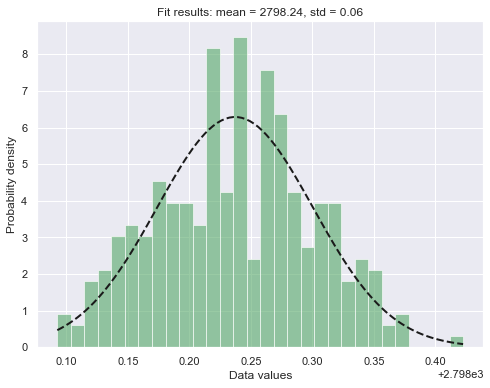

In [39]:
import scipy.stats as stats

# Generate some example .../data data (replace this with your actual data chunk)
data = raw_df_prlm_x_12_5_y_30["anchor_0"][:300]  # mean=10, std=2, 1000 data points

# Calculate the mean and standard deviation of the data
data_mean = np.mean(data)
data_std = np.std(data)

# Fit the data to a normal distribution
pdf_x = np.linspace(np.min(data), np.max(data), 100)
pdf_y = stats.norm.pdf(pdf_x, data_mean, data_std)

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.plot(pdf_x, pdf_y, 'k--', linewidth=2)
plt.title('Fit results: mean = %.2f, std = %.2f' % (data_mean, data_std))
plt.xlabel('Data values')
plt.ylabel('Probability density')
plt.show()